# Load Base Packages

In [2]:
import pandas as pd
import sys
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import loguniform


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

# Preprocess Data (Needed)

In [105]:
data = pd.read_csv("../00_original_data/adult.csv")
data = data.replace("?", None)
data["income"] = data["income"].replace(
    {"<=50K.": 0, "<=50K": 0, ">50K": 1, ">50K.": 1}
)
data.insert(0, "income", data.pop("income"))
data["native-country_United-States"] = (
    data["native-country"] == "United-States"
).astype(int)
data.drop("native-country", axis=1, inplace=True)

# grab numeric cols
numeric_cols = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]
# grab categroical cols
categorical_cols = [
    "native-country_United-States",
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
]

feature_names = data.columns.tolist()[1:]
print(feature_names)

# define categorical and numerical indices for later preprocessing
categorical_columns_indices = [feature_names.index(cn) for cn in categorical_cols]
numerical_columns_indices = [
    feature_names.index(fn) for fn in feature_names if fn not in categorical_cols
]

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country_United-States']


In [109]:
encoder = OneHotEncoder(handle_unknown="ignore")
encoded_data = encoder.fit_transform(data[categorical_cols])

# Create DataFrame for encoded features with proper column naming
new_column_names = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=new_column_names)

In [110]:
encoded_df

native-country_United-States_0  native-country_United-States_1  \
0                                 0.0                             1.0   
1                                 0.0                             1.0   
2                                 0.0                             1.0   
3                                 0.0                             1.0   
4                                 1.0                             0.0   
...                               ...                             ...   
48837                             0.0                             1.0   
48838                             0.0                             1.0   
48839                             0.0                             1.0   
48840                             0.0                             1.0   
48841                             0.0                             1.0   

       workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                        0.0                  0.0                     0.0   
1                        0.0                  0.0                     0.0   
2                        0.0                  0.0                     0.0   
3                        0.0                  0.0                     0.0   
4                        0.0                  0.0                     0.0   
...                      ...                  ...                     ...   
48837                    0.0                  0.0                     0.0   
48838                    0.0                  0.0                     0.0   
48839                    0.0                  0.0                     0.0   
48840                    0.0                  0.0                     0.0   
48841                    0.0                  0.0                     0.0   

       workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
0                    0.0                     0.0                         0.0   
1                    0.0                     0.0                         1.0   
2                    1.0                     0.0                         0.0   
3                    1.0                     0.0                         0.0   
4                    1.0                     0.0                         0.0   
...                  ...                     ...                         ...   
48837                1.0                     0.0                         0.0   
48838                0.0                     0.0                         0.0   
48839                1.0                     0.0                         0.0   
48840                1.0                     0.0                         0.0   
48841                0.0                     1.0                         0.0   

       workclass_State-gov  workclass_Without-pay  ...  \
0                      1.0                    0.0  ...   
1                      0.0                    0.0  ...   
2                      0.0                    0.0  ...   
3                      0.0                    0.0  ...   
4                      0.0                    0.0  ...   
...                    ...                    ...  ...   
48837                  0.0                    0.0  ...   
48838                  0.0                    0.0  ...   
48839                  0.0                    0.0  ...   
48840                  0.0                    0.0  ...   
48841                  0.0                    0.0  ...   

       relationship_Own-child  relationship_Unmarried  relationship_Wife  \
0                         0.0                     0.0                0.0   
1                         0.0                     0.0                0.0   
2                         0.0                     0.0                0.0   
3                         0.0                     0.0                0.0   
4                         0.0                     0.0                1.0   
...                       ...                     ...                ...   
48837          

In [111]:
# Drop the original categorical columns and join the encoded data
data = data.drop(categorical_cols, axis=1)
data = pd.concat([data, encoded_df], axis=1)

In [112]:
feature_names = data.columns.tolist()[1:]
feature_names

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country_United-States_0',
 'native-country_United-States_1',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Never-worked',
 'workclass_Private',
 'workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'workclass_Without-pay',
 'workclass_None',
 'workclass_nan',
 'education_10th',
 'education_11th',
 'education_12th',
 'education_1st-4th',
 'education_5th-6th',
 'education_7th-8th',
 'education_9th',
 'education_Assoc-acdm',
 'education_Assoc-voc',
 'education_Bachelors',
 'education_Doctorate',
 'education_HS-grad',
 'education_Masters',
 'education_Preschool',
 'education_Prof-school',
 'education_Some-college',
 'marital-status_Divorced',
 'marital-status_Married-AF-spouse',
 'marital-status_Married-civ-spouse',
 'marital-status_Married-spouse-absent',
 'marital-status_Never-married',
 'marital-status_Separated',
 'marital-status_Widowed',
 'oc

In [113]:
feature_names = data.columns.tolist()[1:]
# I don't this is neeeded at all
feature_names.remove("fnlwgt")
data.head()

income  age  fnlwgt  education-num  capital-gain  capital-loss  \
0       0   39   77516             13          2174             0   
1       0   50   83311             13             0             0   
2       0   38  215646              9             0             0   
3       0   53  234721              7             0             0   
4       0   28  338409             13             0             0   

   hours-per-week  native-country_United-States_0  \
0              40                             0.0   
1              13                             0.0   
2              40                             0.0   
3              40                             0.0   
4              40                             1.0   

   native-country_United-States_1  workclass_Federal-gov  ...  \
0                             1.0                    0.0  ...   
1                             1.0                    0.0  ...   
2                             1.0                    0.0  ...   
3                             1.0                    0.0  ...   
4                             0.0                    0.0  ...   

   relationship_Own-child  relationship_Unmarried  relationship_Wife  \
0                     0.0                     0.0                0.0   
1                     0.0                     0.0                0.0   
2                     0.0                     0.0                0.0   
3                     0.0                     0.0                0.0   
4                     0.0                     0.0                1.0   

   race_Amer-Indian-Eskimo  race_Asian-Pac-Islander  race_Black  race_Other  \
0                      0.0                      0.0         0.0         0.0   
1                      0.0                      0.0         0.0         0.0   
2                      0.0                      0.0         0.0         0.0   
3                      0.0                      0.0         1.0         0.0   
4                      0.0                      0.0         1.0         0.0   

   race_White  sex_Female  sex_Male  
0         1.0         0.0       1.0  
1         1.0         0.0       1.0  
2         1.0         0.0       1.0  
3         0.0         0.0       1.0  
4         0.0         1.0       0.0  

[5 rows x 71 columns]

# IF NO PREPROCESSING IS NEEDED 

In [85]:
# check ohe data
data = pd.read_csv("../01_clean_data/adult_ohe.csv")
data.head()

income  Age  Education Level  Dollar gain of capital  \
0       0   39               13                    2174   
1       0   50               13                       0   
2       0   38                9                       0   
3       0   53                7                       0   
4       0   28               13                       0   

   Dollar loss of capital  Working hours per week  US Native: (No)  \
0                       0                      40              0.0   
1                       0                      13              0.0   
2                       0                      40              0.0   
3                       0                      40              0.0   
4                       0                      40              1.0   

   US Native: (Yes)  Work Class: Federal Government  \
0               1.0                             0.0   
1               1.0                             0.0   
2               1.0                             0.0   
3               1.0                             0.0   
4               0.0                             0.0   

   Work Class: Local Government  ...  Relationship: Own Child  \
0                           0.0  ...                      0.0   
1                           0.0  ...                      0.0   
2                           0.0  ...                      0.0   
3                           0.0  ...                      0.0   
4                           0.0  ...                      0.0   

   Relationship: Unmarried  Relationship: Wife  Race: Amer Indian Eskimo  \
0                      0.0                 0.0                       0.0   
1                      0.0                 0.0                       0.0   
2                      0.0                 0.0                       0.0   
3                      0.0                 0.0                       0.0   
4                      0.0                 1.0                       0.0   

   Race: Asian Pac Islander  Race: Black  Race: Other  Race: White  \
0                       0.0          0.0          0.0          1.0   
1                       0.0          0.0          0.0          1.0   
2                       0.0          0.0          0.0          1.0   
3                       0.0          1.0          0.0          0.0   
4                       0.0          1.0          0.0          0.0   

   Sex: Female  Sex: Male  
0          0.0        1.0  
1          0.0        1.0  
2          0.0        1.0  
3          0.0        1.0  
4          1.0        0.0  

[5 rows x 54 columns]

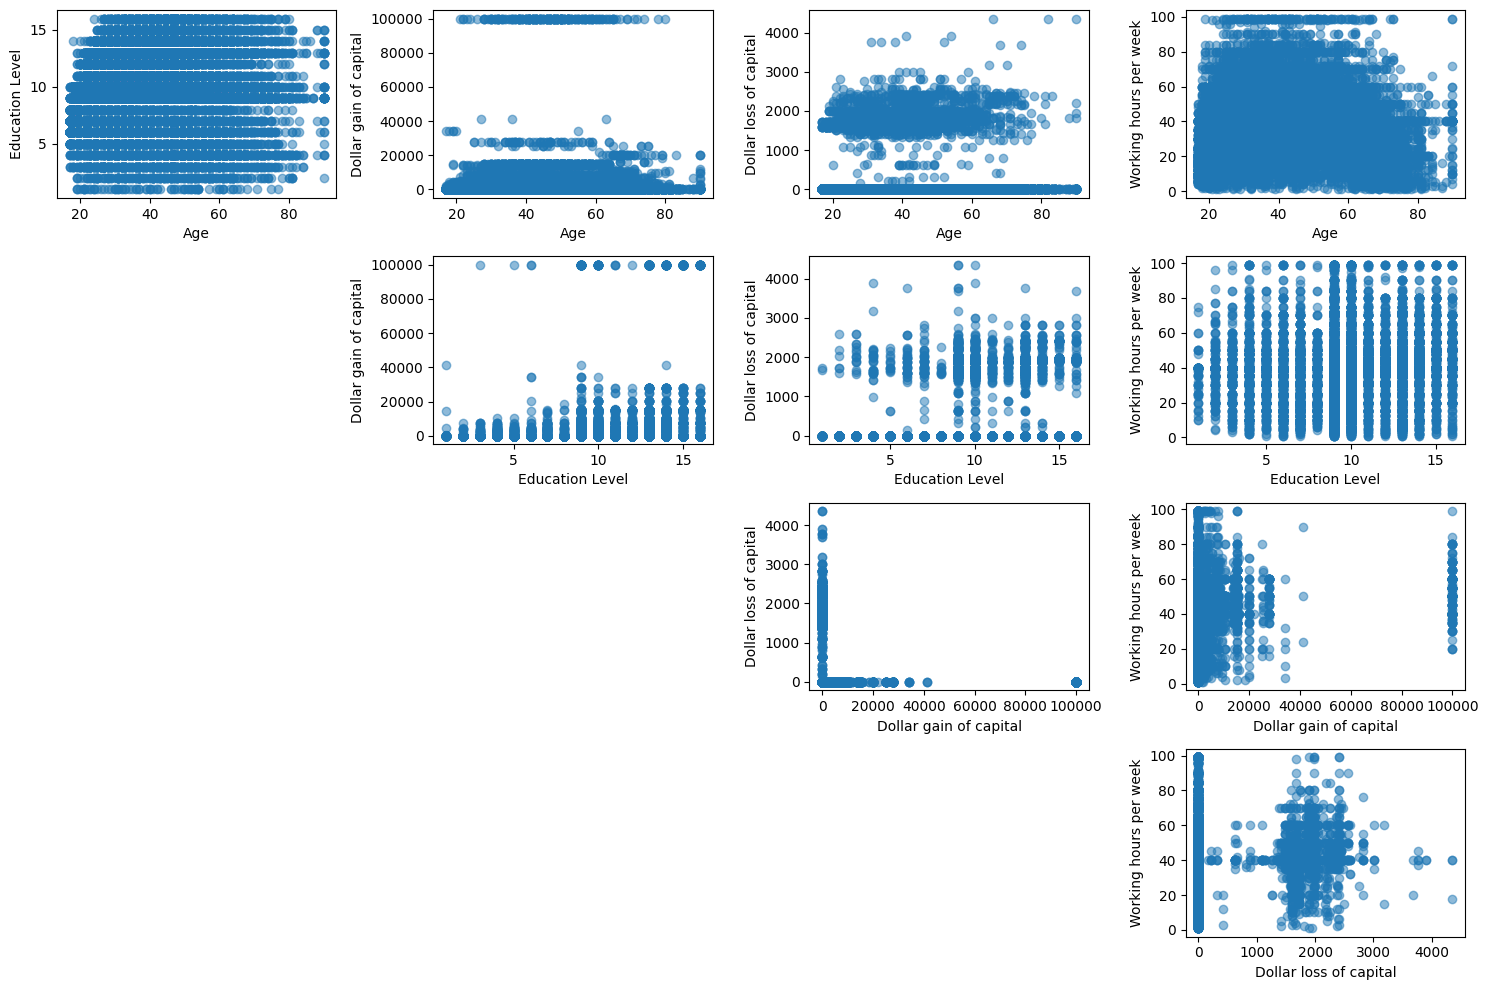

In [86]:
numeric_cols = [
    "Age",
    "Education Level",
    "Dollar gain of capital",
    "Dollar loss of capital",
    "Working hours per week",
]

# Plot scatter plots for each pair of numeric columns
plt.figure(figsize=(15, 10))
for i in range(len(numeric_cols)):
    for j in range(i + 1, len(numeric_cols)):
        plt.subplot(
            len(numeric_cols) - 1,
            len(numeric_cols) - 1,
            (i) * (len(numeric_cols) - 1) + j,
        )
        plt.scatter(data[numeric_cols[i]], data[numeric_cols[j]], alpha=0.5)
        plt.xlabel(numeric_cols[i])
        plt.ylabel(numeric_cols[j])

plt.tight_layout()
plt.show()

In [87]:
feature_names = data.columns.tolist()[1:]
feature_names

['Age',
 'Education Level',
 'Dollar gain of capital',
 'Dollar loss of capital',
 'Working hours per week',
 'US Native: (No)',
 'US Native: (Yes)',
 'Work Class: Federal Government',
 'Work Class: Local Government',
 'Work Class: Never Worked',
 'Work Class: Private',
 'Work Class: Self Employed (Incorporated)',
 'Work Class: Self Employed (Not Incorporated)',
 'Work Class: State Government',
 'Work Class: Without Pay',
 'Work Class: None',
 'Work Class: Not Available',
 'Marital Status: Divorced',
 'Marital Status: Married (AF Spouse)',
 'Marital Status: Married (Civilian Spouse)',
 'Marital Status: Married (Spouse Absent)',
 'Marital Status: Never Married',
 'Marital Status: Separated',
 'Marital Status: Widowed',
 'Occupation: Administrative Clerical',
 'Occupation: Armed Forces',
 'Occupation: Craft Repair',
 'Occupation: Executive Managerial',
 'Occupation: Farming Fishing',
 'Occupation: Handlers Cleaners',
 'Occupation: Machine Op Inspection',
 'Occupation: Other Service',
 'O

In [88]:
# extract data
X_ohe = data[feature_names]
y = data["income"]

X_full, X_test, y_full, y_test = train_test_split(
    X_ohe, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.20, random_state=42
)

In [89]:
na_percentage = (X_val.isnull().mean()).sort_values(ascending=False).head()
print("(a) current na percentage of ohe dataset")
na_percentage

(a) current na percentage of ohe dataset


Age                                  0.0
Occupation: Executive Managerial     0.0
Occupation: Handlers Cleaners        0.0
Occupation: Machine Op Inspection    0.0
Occupation: Other Service            0.0
dtype: float64

In [91]:
numeric_cols = [
    "Age",
    "Education Level",
    "Dollar gain of capital",
    "Dollar loss of capital",
    "Working hours per week",
]
scaler = StandardScaler()
X_ohe[numeric_cols] = scaler.fit_transform(X_ohe[numeric_cols])
# should be same sampling as original
X_full_ss, X_test_ss, y_full_ss, y_test_ss = train_test_split(
    X_ohe, y, test_size=0.2, random_state=42
)
# should be same sampling as original
X_train_ss, X_val_ss, y_train_ss, y_val_ss = train_test_split(
    X_full_ss, y_full_ss, test_size=0.20, random_state=42
)

In [92]:
X_train_ss.head()

Age  Education Level  Dollar gain of capital  \
10158 -1.359816        -1.586221               -0.144804   
9517  -0.849254         1.136512               -0.144804   
26495  0.025996        -0.419335               -0.144804   
45350 -1.141004        -0.030373               -0.144804   
11996  3.745808         1.136512               -0.144804   

       Dollar loss of capital  Working hours per week  US Native: (No)  \
10158               -0.217127               -0.034087              0.0   
9517                -0.217127               -0.034087              0.0   
26495               -0.217127               -0.034087              0.0   
45350               -0.217127               -0.034087              0.0   
11996               -0.217127                1.176438              0.0   

       US Native: (Yes)  Work Class: Federal Government  \
10158               1.0                             0.0   
9517                1.0                             0.0   
26495               1.0                             0.0   
45350               1.0                             0.0   
11996               1.0                             0.0   

       Work Class: Local Government  Work Class: Never Worked  ...  \
10158                           0.0                       0.0  ...   
9517                            1.0                       0.0  ...   
26495                           0.0                       0.0  ...   
45350                           0.0                       0.0  ...   
11996                           0.0                       0.0  ...   

       Relationship: Own Child  Relationship: Unmarried  Relationship: Wife  \
10158                      0.0                      0.0                 0.0   
9517                       1.0                      0.0                 0.0   
26495                      0.0                      0.0                 0.0   
45350                      1.0                      0.0                 0.0   
11996                      0.0                      0.0                 0.0   

       Race: Amer Indian Eskimo  Race: Asian Pac Islander  Race: Black  \
10158                       0.0                       0.0          0.0   
9517                        0.0                       0.0          0.0   
26495                       0.0                       0.0          0.0   
45350                       0.0                       0.0          0.0   
11996                       0.0                       0.0          0.0   

       Race: Other  Race: White  Sex: Female  Sex: Male  
10158          0.0          1.0          0.0        1.0  
9517           0.0          1.0          1.0        0.0  
26495          0.0          1.0          0.0        1.0  
45350          0.0          1.0          0.0        1.0  
11996          0.0          1.0          0.0        1.0  

[5 rows x 53 columns]

In [93]:
X_train.head()

Age  Education Level  Dollar gain of capital  Dollar loss of capital  \
10158   20                6                       0                       0   
9517    27               13                       0                       0   
26495   39                9                       0                       0   
45350   23               10                       0                       0   
11996   90               13                       0                       0   

       Working hours per week  US Native: (No)  US Native: (Yes)  \
10158                      40              0.0               1.0   
9517                       40              0.0               1.0   
26495                      40              0.0               1.0   
45350                      40              0.0               1.0   
11996                      55              0.0               1.0   

       Work Class: Federal Government  Work Class: Local Government  \
10158                             0.0                           0.0   
9517                              0.0                           1.0   
26495                             0.0                           0.0   
45350                             0.0                           0.0   
11996                             0.0                           0.0   

       Work Class: Never Worked  ...  Relationship: Own Child  \
10158                       0.0  ...                      0.0   
9517                        0.0  ...                      1.0   
26495                       0.0  ...                      0.0   
45350                       0.0  ...                      1.0   
11996                       0.0  ...                      0.0   

       Relationship: Unmarried  Relationship: Wife  Race: Amer Indian Eskimo  \
10158                      0.0                 0.0                       0.0   
9517                       0.0                 0.0                       0.0   
26495                      0.0                 0.0                       0.0   
45350                      0.0                 0.0                       0.0   
11996                      0.0                 0.0                       0.0   

       Race: Asian Pac Islander  Race: Black  Race: Other  Race: White  \
10158                       0.0          0.0          0.0          1.0   
9517                        0.0          0.0          0.0          1.0   
26495                       0.0          0.0          0.0          1.0   
45350                       0.0          0.0          0.0          1.0   
11996                       0.0          0.0          0.0          1.0   

       Sex: Female  Sex: Male  
10158          0.0        1.0  
9517           1.0        0.0  
26495          0.0        1.0  
45350          0.0        1.0  
11996          0.0        1.0  

[5 rows x 53 columns]

# Load and Split Dataset

In [186]:
# adult_ohe = pd.read_csv("../01_clean_data/adult_ohe.csv")

# X = adult_ohe.drop(columns=["income"])
# y = adult_ohe["income"]

# # need to do preprorcessing here and check if this will work proprely


# # make sure to have train, val, and test
# # I orginally messed up here where I only did a train and val split, so the model needs to be retrained on random
# # I move on to make sure we have global-agonstic methods established
# X_full, X_test, y_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(
#     X_full, y_full, test_size=0.20, random_state=42
# )

# Build Catboost Classifier

In [94]:
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
y_train = y_train.copy()
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [59]:
# implement random search to find good params
param_grid = {
    "depth": [2, 6, 8, 10, 12, 14],
    "learning_rate": loguniform(1e-5, 1e-0),
    "iterations": [500, 800, 1000, 1200],
    "l2_leaf_reg": [2, 4, 6, 8, 10, 12, 14],
    "boosting_type": ["Ordered"],
    "logging_level": ["Silent"],
    "loss_function": ["Logloss"],
    "class_weights": [class_weights],
}

random_search = RandomizedSearchCV(
    estimator=CatBoostClassifier(),
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
)

random_search.fit(X_train, y_train)
print("Catboost random search model has been fitted")

Catboost random search model has been fitted


In [61]:
# calc scores on validation data
best_random_catboost = random_search.best_estimator_
# calc scores on validation data
y_pred_proba = best_random_catboost.predict_proba(X_val)[:, 1]
auc_random = roc_auc_score(y_val, y_pred_proba)
ap_random = average_precision_score(y_val, y_pred_proba)
print("ROC_AUC score:", auc_random)
print("AP score:", ap_random)

ROC_AUC score: 0.929373792156224
AP score: 0.8342370137312383


In [96]:
merged_params = {
    "boosting_type": "Ordered",
    "class_weights": {0: 0.6551391683433937, 1: 2.1114563631450958},
    "depth": 10,
    "iterations": 800,
    "l2_leaf_reg": 14,
    "learning_rate": 0.40679084943595434,
    "logging_level": "Silent",
    "loss_function": "Logloss",
}
print("The best params for the Catboost Classifier are: ")
merged_params

The best params for the Catboost Classifier are: 


{'boosting_type': 'Ordered',
 'class_weights': {0: 0.6551391683433937, 1: 2.1114563631450958},
 'depth': 10,
 'iterations': 800,
 'l2_leaf_reg': 14,
 'learning_rate': 0.40679084943595434,
 'logging_level': 'Silent',
 'loss_function': 'Logloss'}

# Refit with train+val data and see how it performs on test data

In [97]:
catboost_final = CatBoostClassifier(**merged_params)
catboost_final.fit(X_full, y_full)

In [98]:
y_pred_proba = catboost_final.predict_proba(X_test)[:, 1]
auc_final = roc_auc_score(y_test, y_pred_proba)
ap_final = average_precision_score(y_test, y_pred_proba)
print("ROC_AUC score:", auc_final)
print("AP score:", ap_final)
y_pred = catboost_final.predict(X_test)

accuracy_final = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

print("Accuracy:", accuracy_final)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

ROC_AUC score: 0.9276111299160308
AP score: 0.828862129243662
Accuracy: 0.8291534445695568
Precision: 0.6011202830188679
Recall: 0.8658174097664544
F1 Score: 0.7095876109274404


In [99]:
feature_int = catboost_final.get_feature_importance(fstr_type="Interaction")
for ft in feature_int:
    print(feature_names[int(ft[0])], feature_names[int(ft[1])], ft[2])

Age Dollar loss of capital 5.460956688487836
Dollar gain of capital Dollar loss of capital 5.357629765371172
Education Level Dollar gain of capital 4.4939270957306094
Age Education Level 4.0455773895284945
Education Level Dollar loss of capital 3.8922022653868784
Age Dollar gain of capital 3.593141301294658
Dollar loss of capital Working hours per week 3.3446673194240466
Age Working hours per week 2.968302226665137
Dollar gain of capital Working hours per week 2.4526636963986768
Dollar gain of capital Marital Status: Married (AF Spouse) 2.143296101558899
Education Level Marital Status: Married (Civilian Spouse) 2.0121398181217023
Education Level Occupation: Armed Forces 1.9175365511718234
Dollar gain of capital Marital Status: Married (Civilian Spouse) 1.7814844777520669
Education Level Working hours per week 1.2559858966590711
Dollar gain of capital Occupation: Farming Fishing 1.251380112049268
Age Marital Status: Married (Civilian Spouse) 0.9976909879820348
Age Occupation: Farming Fi

# Global-Agonistic Methods

### SHAP Feature Importance

In [66]:
import shap


def f(x):
    return catboost_final.predict_proba(x)[:, 1]


# baseline for comparion
med = X_full.median().values.reshape((1, X_full.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test)

PermutationExplainer explainer: 9770it [01:46, 82.79it/s]                           


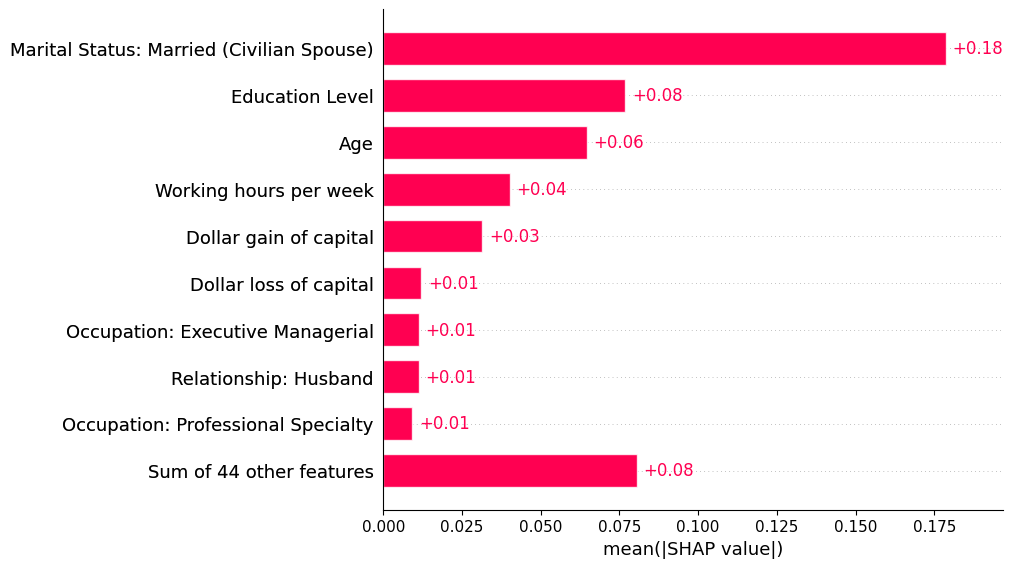

In [67]:
shap.plots.bar(shap_values)

### Partial Dependecy Plots

In [28]:
X_full.columns

Index(['Age', 'Education Level', 'Dollar gain of capital',
       'Dollar loss of capital', 'Working hours per week', 'US Native: (No)',
       'US Native: (Yes)', 'Work Class: Federal Government',
       'Work Class: Local Government', 'Work Class: Never Worked',
       'Work Class: Private', 'Work Class: Self Employed (Incorporated)',
       'Work Class: Self Employed (Not Incorporated)',
       'Work Class: State Government', 'Work Class: Without Pay',
       'Work Class: None', 'Work Class: Not Available',
       'Marital Status: Divorced', 'Marital Status: Married (AF Spouse)',
       'Marital Status: Married (Civilian Spouse)',
       'Marital Status: Married (Spouse Absent)',
       'Marital Status: Never Married', 'Marital Status: Separated',
       'Marital Status: Widowed', 'Occupation: Administrative Clerical',
       'Occupation: Armed Forces', 'Occupation: Craft Repair',
       'Occupation: Executive Managerial', 'Occupation: Farming Fishing',
       'Occupation: Handlers 

In [100]:
# pip install pdpbox
from pdpbox import pdp, info_plots
from sklearn.preprocessing import StandardScaler

# going though examples for team so it won't be complete, but will finish later
X_full_copy = X_full.copy()


# use this to transfrom origianl scaled data
def data_trans(df, scaler=scaler):
    numeric_cols = [
        "Age",
        "Education Level",
        "Dollar gain of capital",
        "Dollar loss of capital",
        "Working hours per week",
    ]
    df[numeric_cols] = scaler.transform(df[numeric_cols])
    return df


# numerical feature
pdp_age = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature="Age",
    feature_name="Age",
    data_transformer=data_trans,
    n_classes=2,
)

# "age" is scaled so this will cause issues, will talk to Babara about this
# scaling the data isn't feasible
# when you scale your data, the original meaning of the features may become less directly interpretable

fig, axes = pdp_age.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=1000,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [117]:
X_full_copy = X_full.copy()

pdp_age_fare = pdp.PDPInteract(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    features=["Age", "Education Level"],
    feature_names=["Age", "Education Level"],
    data_transformer=data_trans,
    n_classes=2,
    chunk_size=-1,
    n_jobs=1,
    num_grid_points=15,
    grid_types="percentile",
    percentile_ranges=None,
    grid_ranges=None,
    cust_grid_points=None,
)

fig, axes = pdp_age_fare.plot(
    plot_type="grid",
    plot_pdp=True,
    to_bins=True,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="plotly",
    template="plotly_white",
)
fig

obtain pred_func from the provided model.


  0%|          | 0/15 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/8 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/120 [00:00<?, ?it/s]

In [122]:
marrige_columns = [col for col in X_full.columns if col.startswith("Marital Status")]
marrige_columns.append("Age")

In [128]:
X_full_copy = X_full.copy()

pdp_age_fare = pdp.PDPInteract(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    features=["Age", "Marital Status: Married (Civilian Spouse)"],
    feature_names=["Age", "Marital Status: Married (Civilian Spouse)"],
    data_transformer=data_trans,
    n_classes=2,
    chunk_size=-1,
    n_jobs=1,
    num_grid_points=15,
    grid_types="percentile",
    percentile_ranges=None,
    grid_ranges=None,
    cust_grid_points=None,
)

fig, axes = pdp_age_fare.plot(
    plot_type="grid",
    plot_pdp=True,
    to_bins=True,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="plotly",
    template="plotly_white",
)
fig

obtain pred_func from the provided model.


  0%|          | 0/15 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/150 [00:00<?, ?it/s]

In [129]:
X_full_copy = X_full.copy()

pdp_age_fare = pdp.PDPInteract(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    features=["Age", "Working hours per week"],
    feature_names=["Age", "Working hours per week"],
    data_transformer=data_trans,
    n_classes=2,
    chunk_size=-1,
    n_jobs=1,
    num_grid_points=15,
    grid_types="percentile",
    percentile_ranges=None,
    grid_ranges=None,
    cust_grid_points=None,
)

fig, axes = pdp_age_fare.plot(
    plot_type="grid",
    plot_pdp=True,
    to_bins=True,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="plotly",
    template="plotly_white",
)
fig

obtain pred_func from the provided model.


  0%|          | 0/15 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/150 [00:00<?, ?it/s]

In [133]:
X_full_copy = X_full.copy()

pdp_age_fare = pdp.PDPInteract(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    features=["Education Level", "Marital Status: Married (Civilian Spouse)"],
    feature_names=[
        "Eductation Level",
        "Marital Status: Married (Civilian Spouse)",
    ],
    data_transformer=data_trans,
    n_classes=2,
    chunk_size=-1,
    n_jobs=1,
    num_grid_points=15,
    grid_types="percentile",
    percentile_ranges=None,
    grid_ranges=None,
    cust_grid_points=None,
)

fig, axes = pdp_age_fare.plot(
    plot_type="grid",
    plot_pdp=True,
    to_bins=True,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="plotly",
    template="plotly_white",
)
fig

ValueError: feature does not exist: {'Eductation level'}

obtain pred_func from the provided model.


  0%|          | 0/7 [00:00<?, ?it/s]

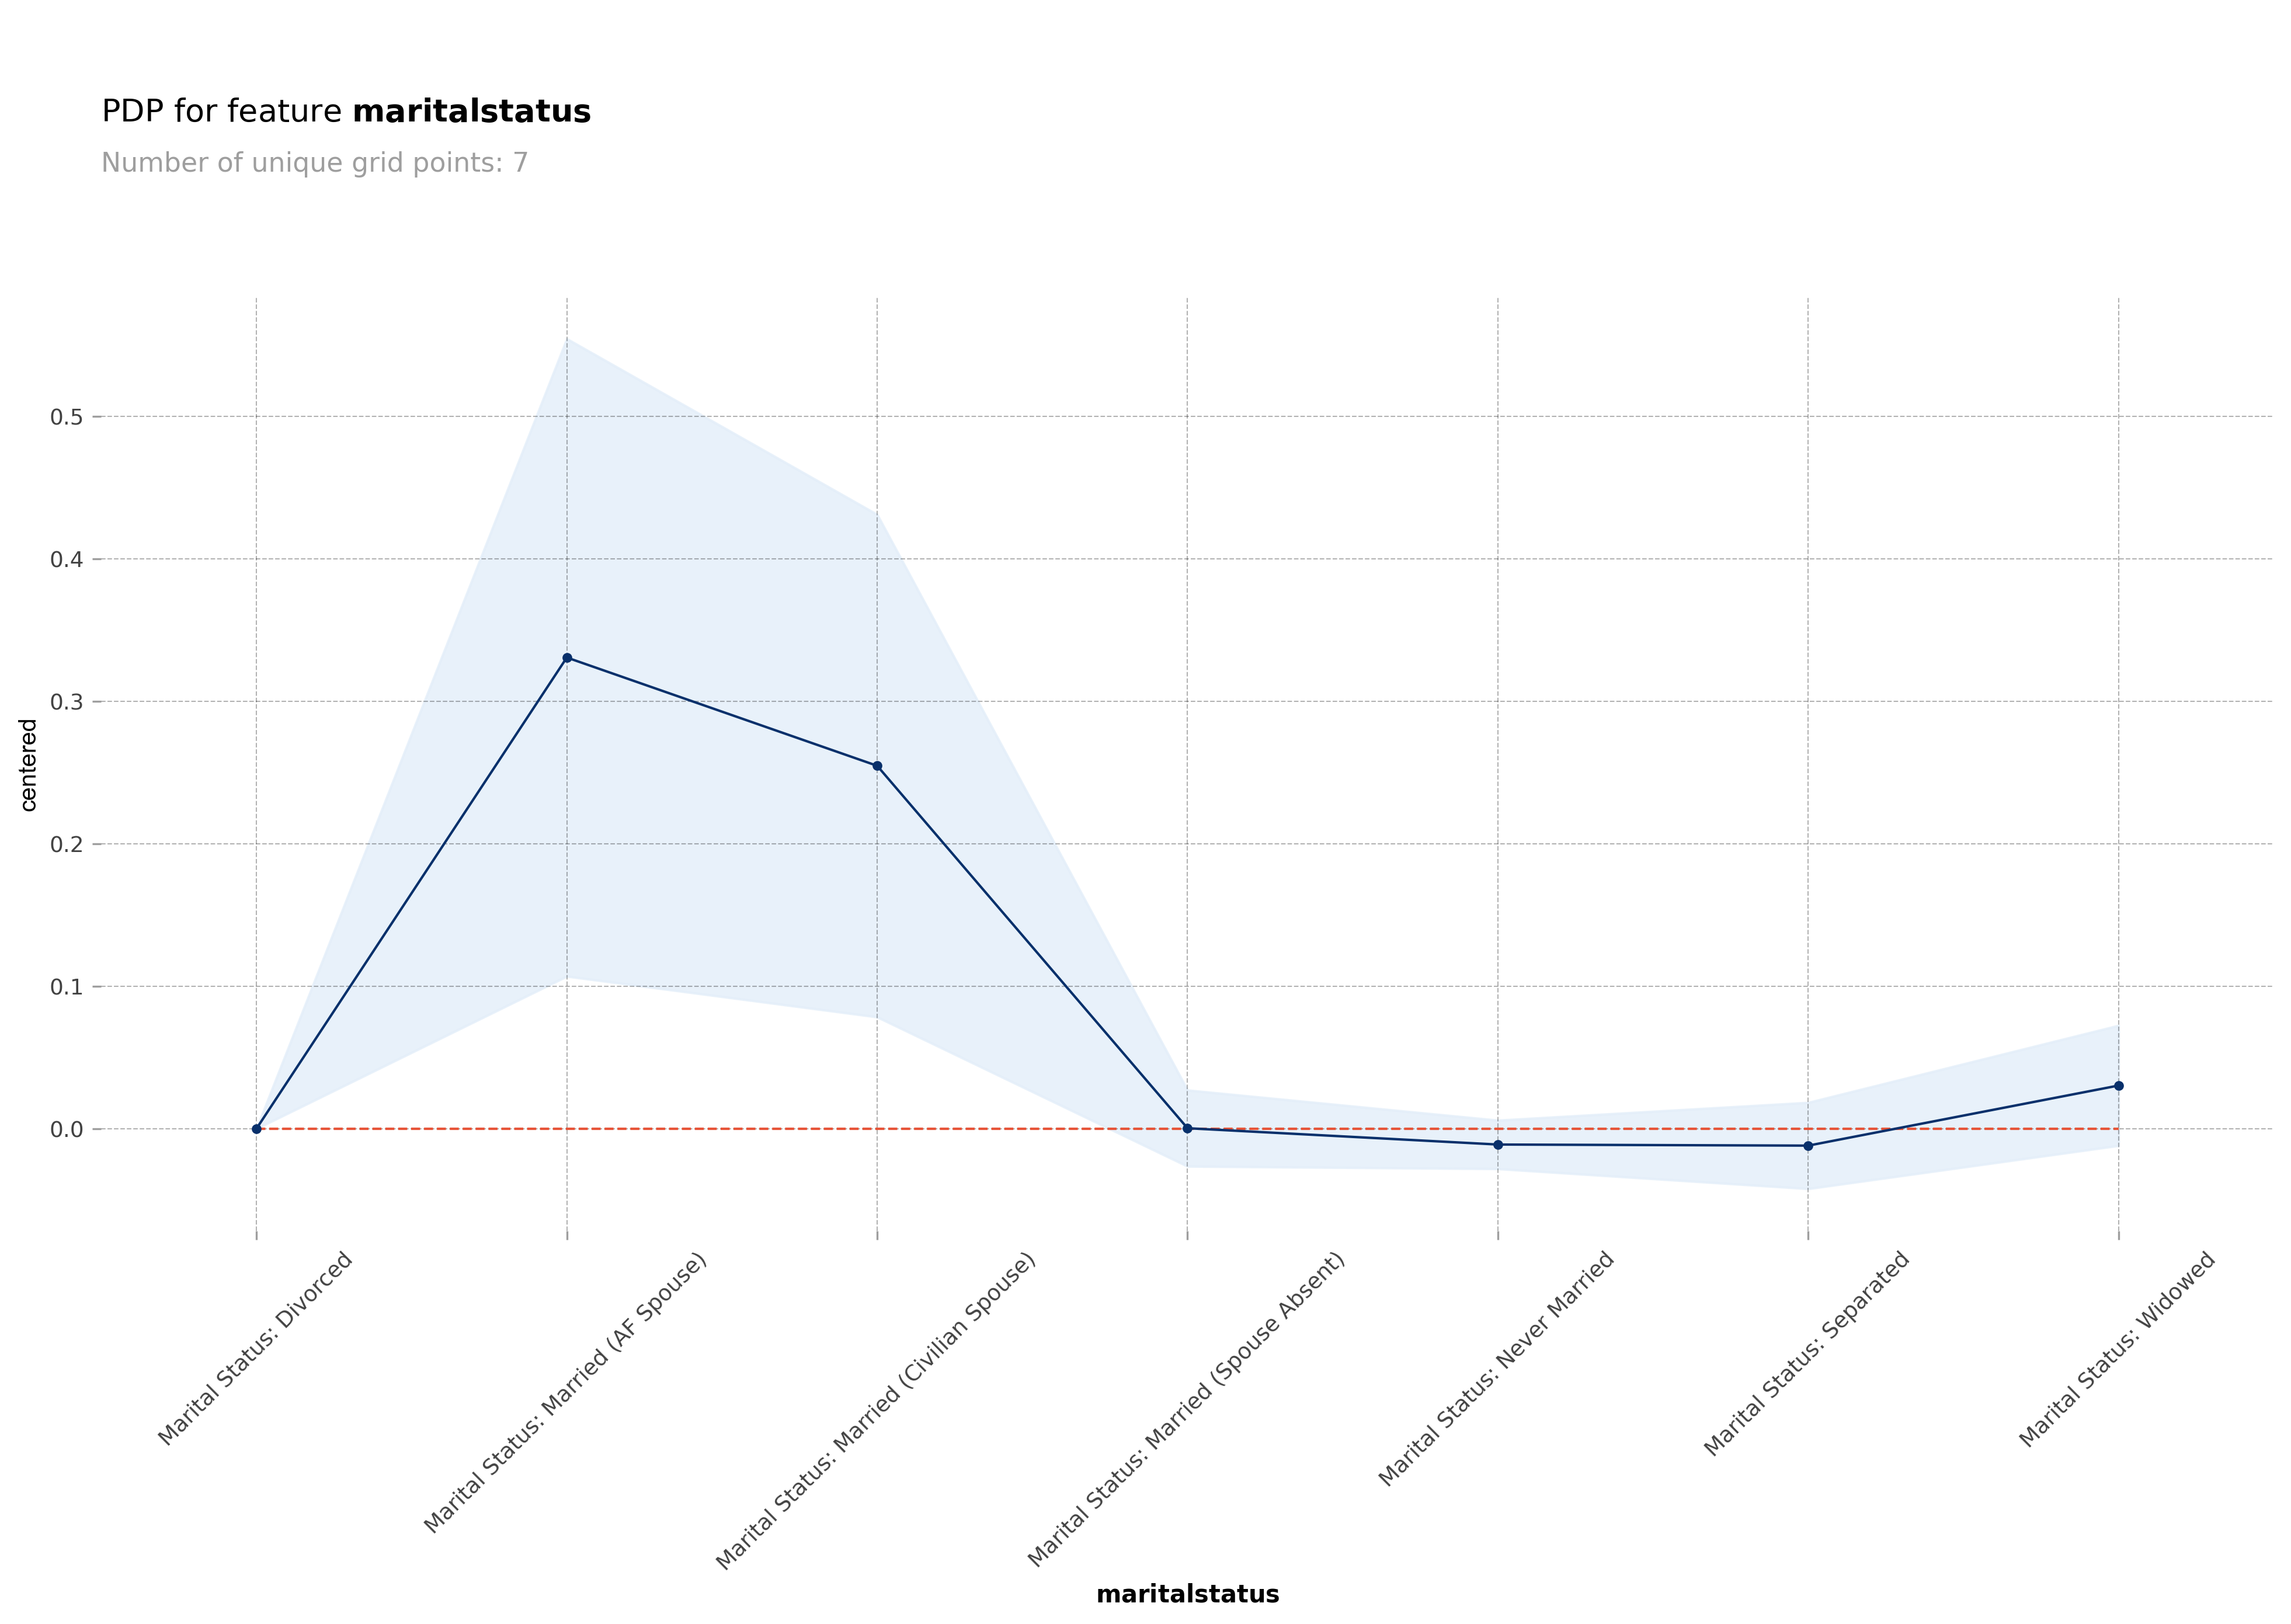

In [39]:
# categorical feature
X_full_copy = X_full.copy()

pdp_married = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature=marrige_columns,
    feature_name="marital status",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_married.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.xticks(rotation=45)

# Show the plot
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/6 [00:00<?, ?it/s]

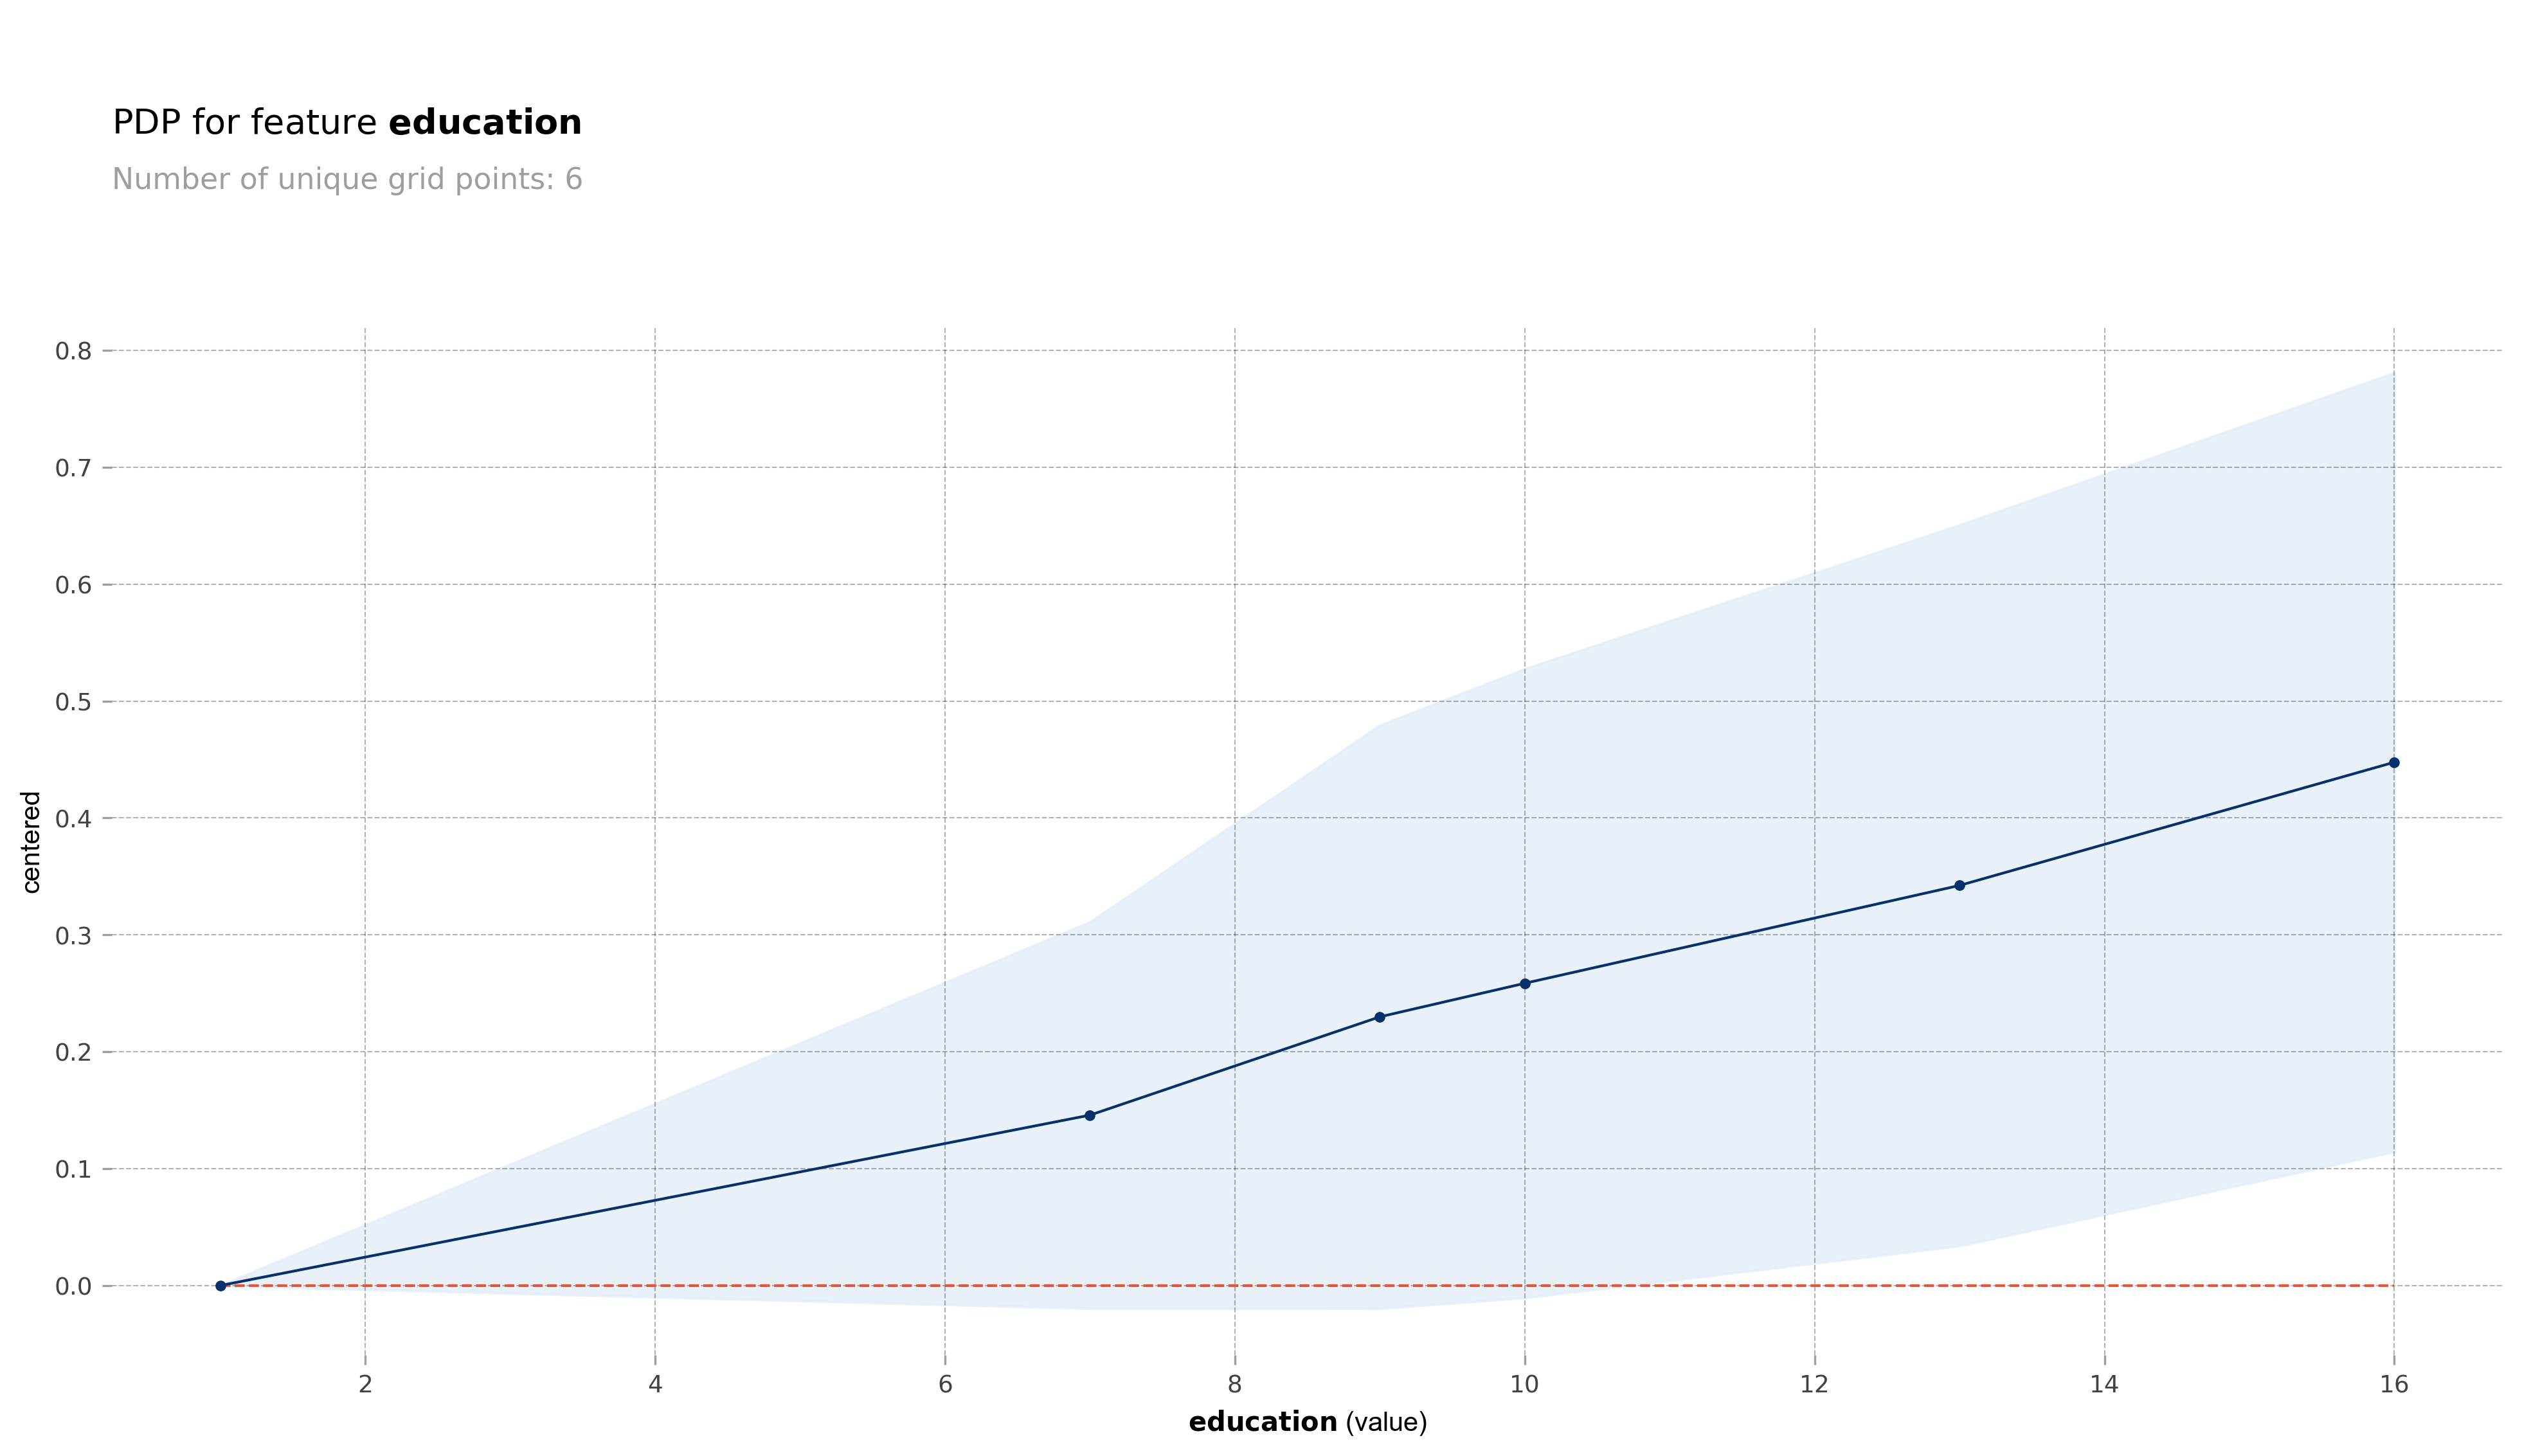

In [41]:
# education level
X_full_copy = X_full.copy()

pdp_education = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature="Education Level",
    feature_name="education",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_education.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
# Show the plot
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/7 [00:00<?, ?it/s]

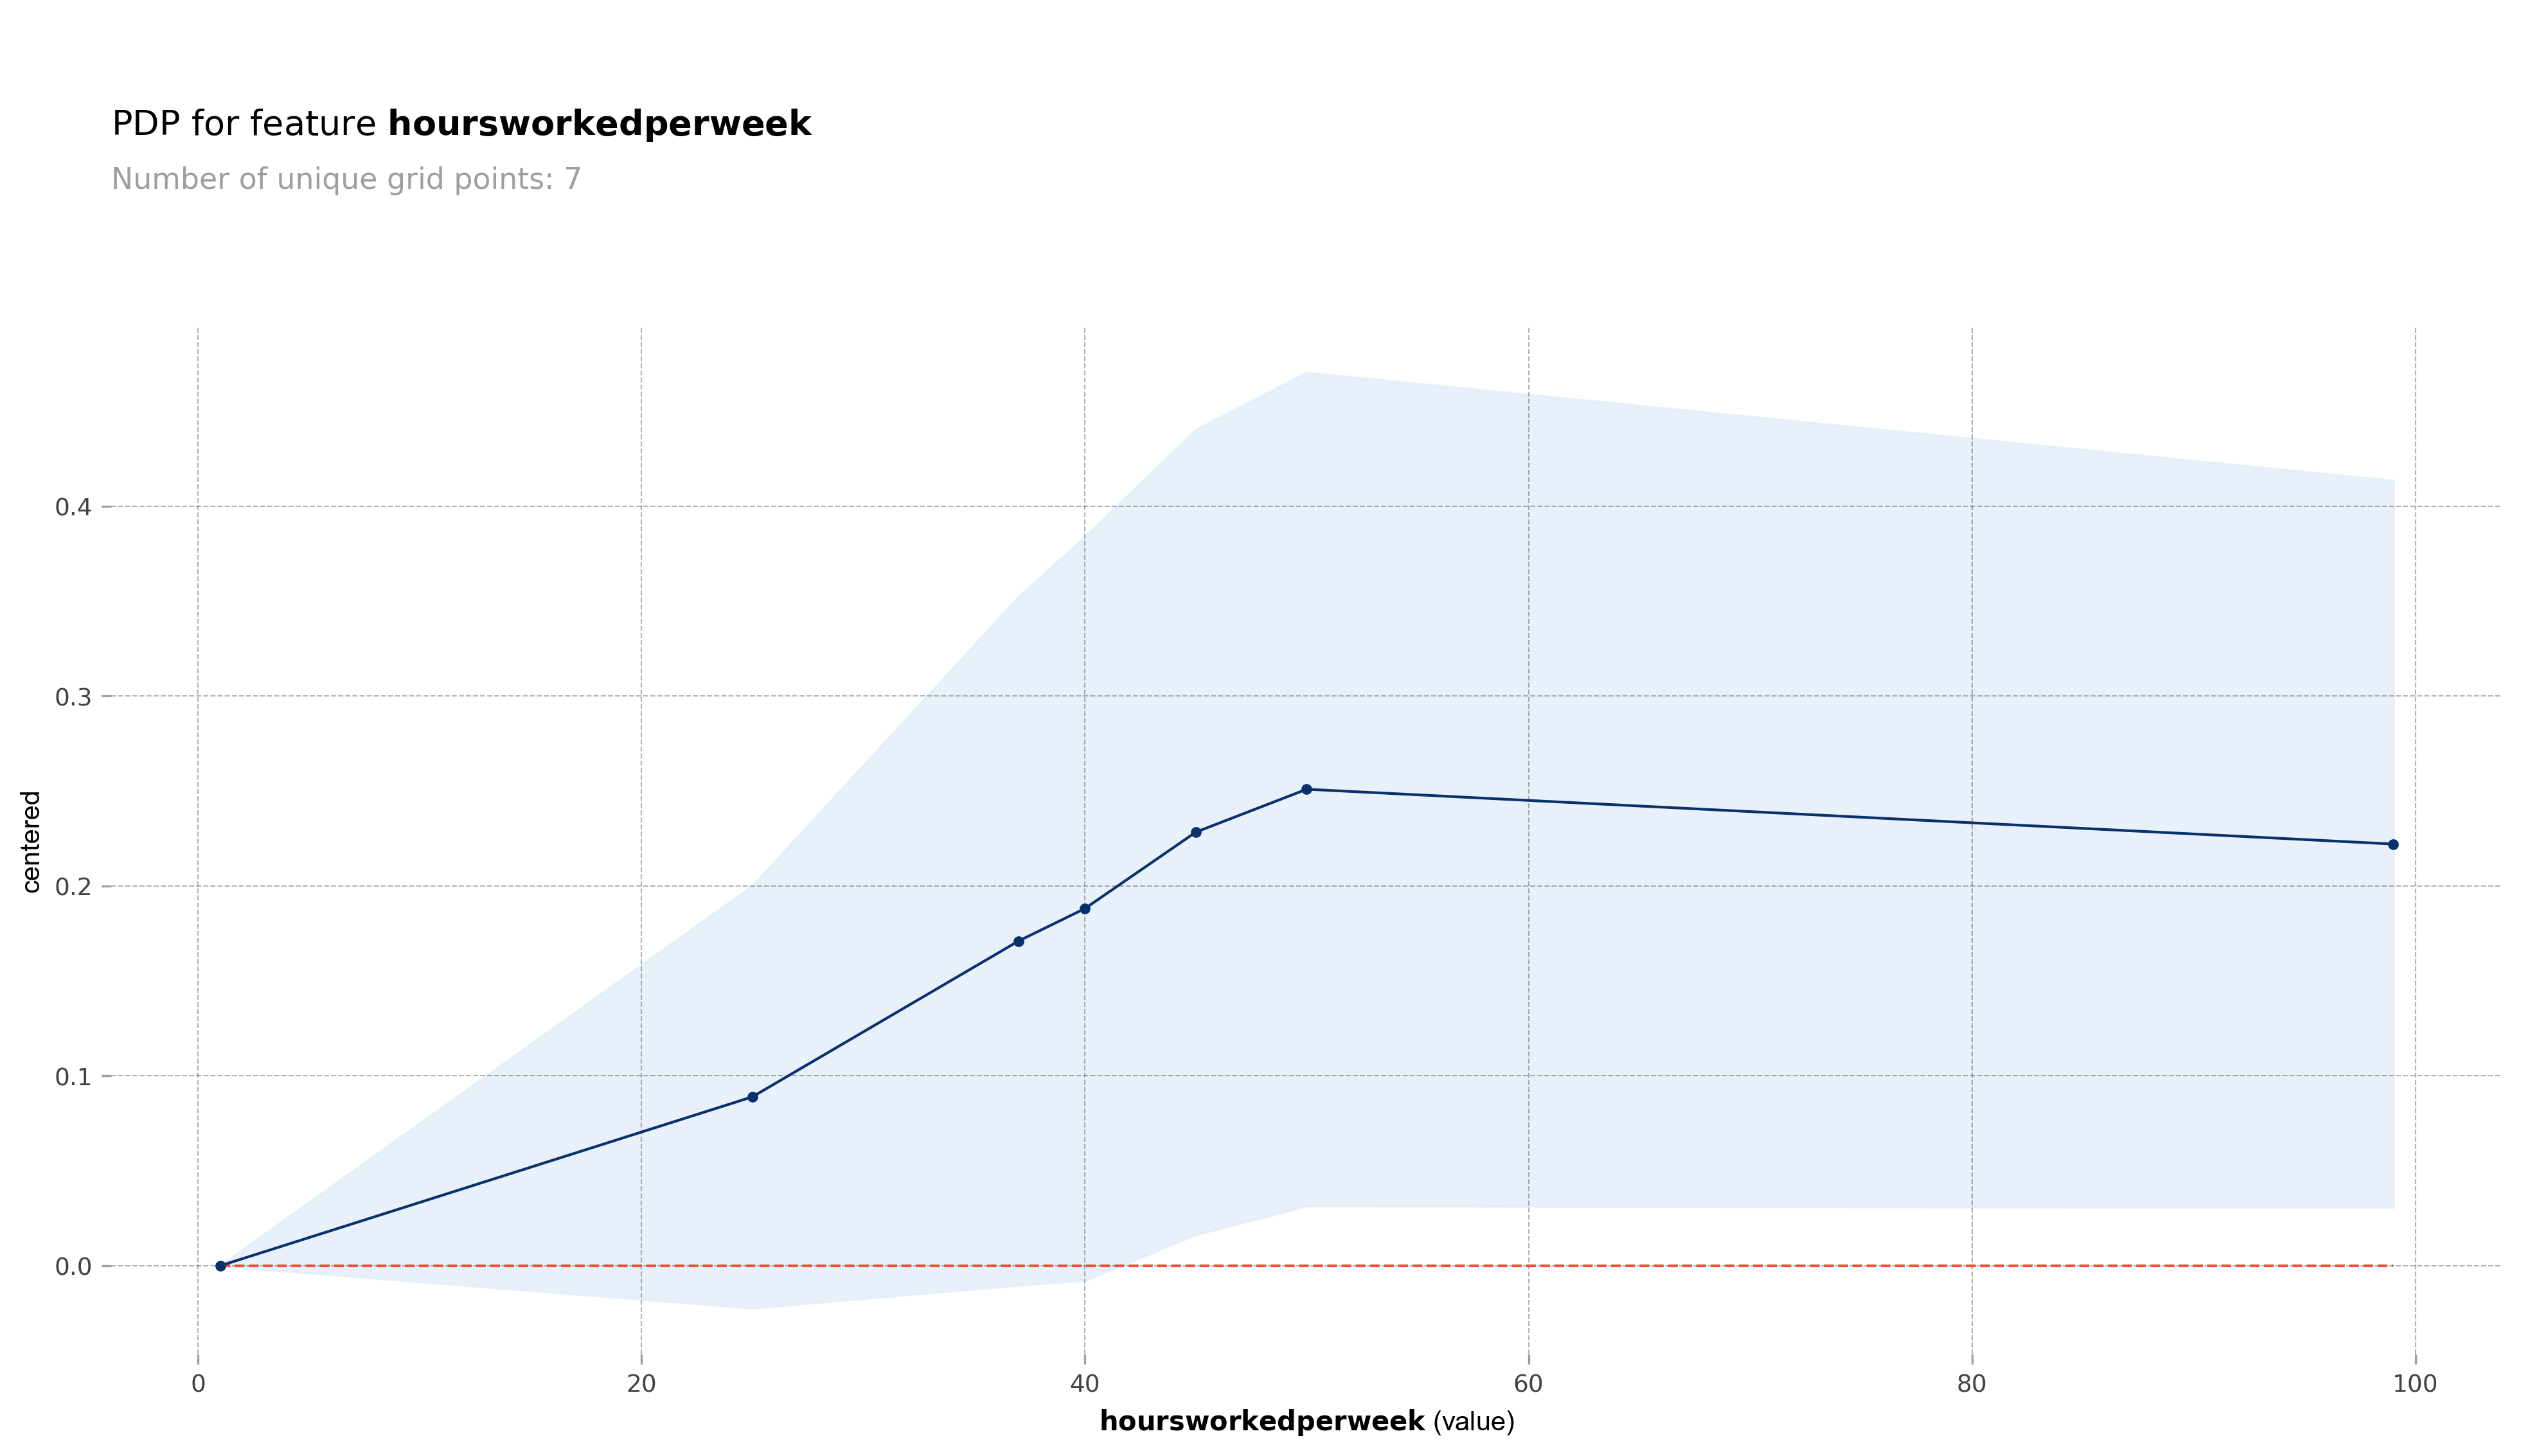

In [42]:
# hours-per-week
X_full_copy = X_full.copy()

pdp_hours = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature="Working hours per week",
    feature_name="hoursworkedperweek",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_hours.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
# Show the plot
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

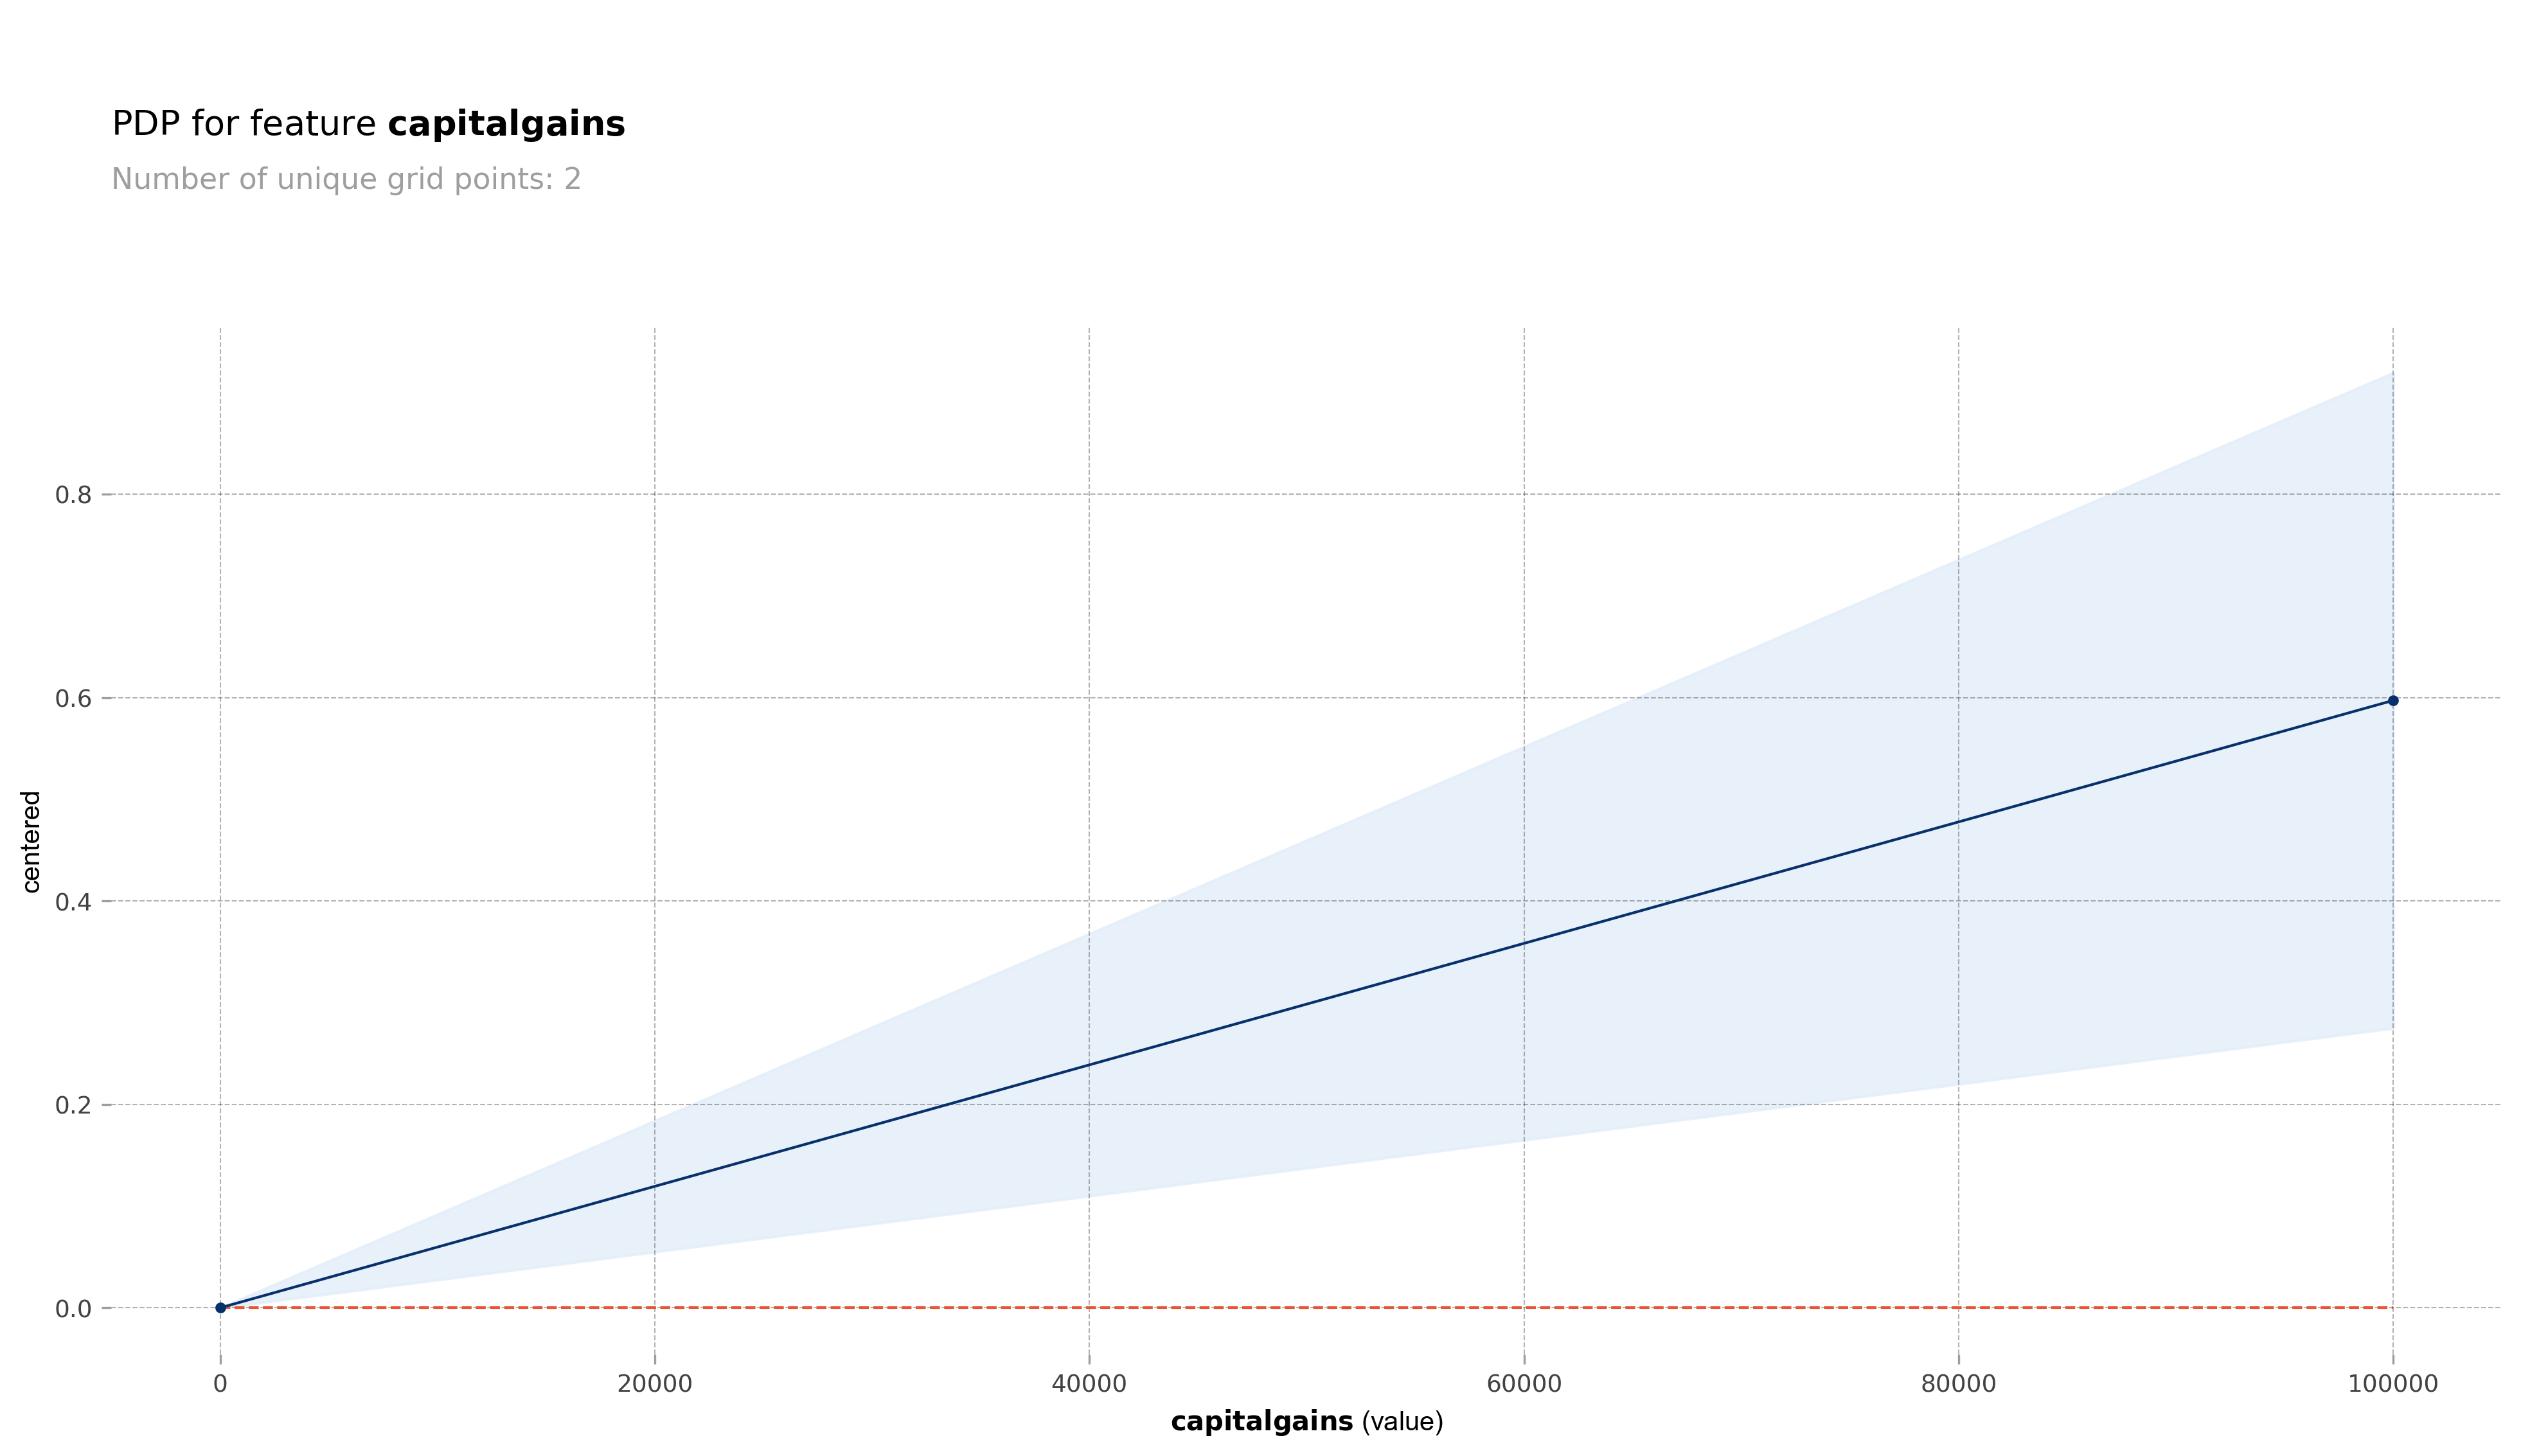

In [43]:
# captial gains
X_full_copy = X_full.copy()

pdp_cp = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature="Dollar gain of capital",
    feature_name="capital gains",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_cp.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
# Show the plot
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/16 [00:00<?, ?it/s]

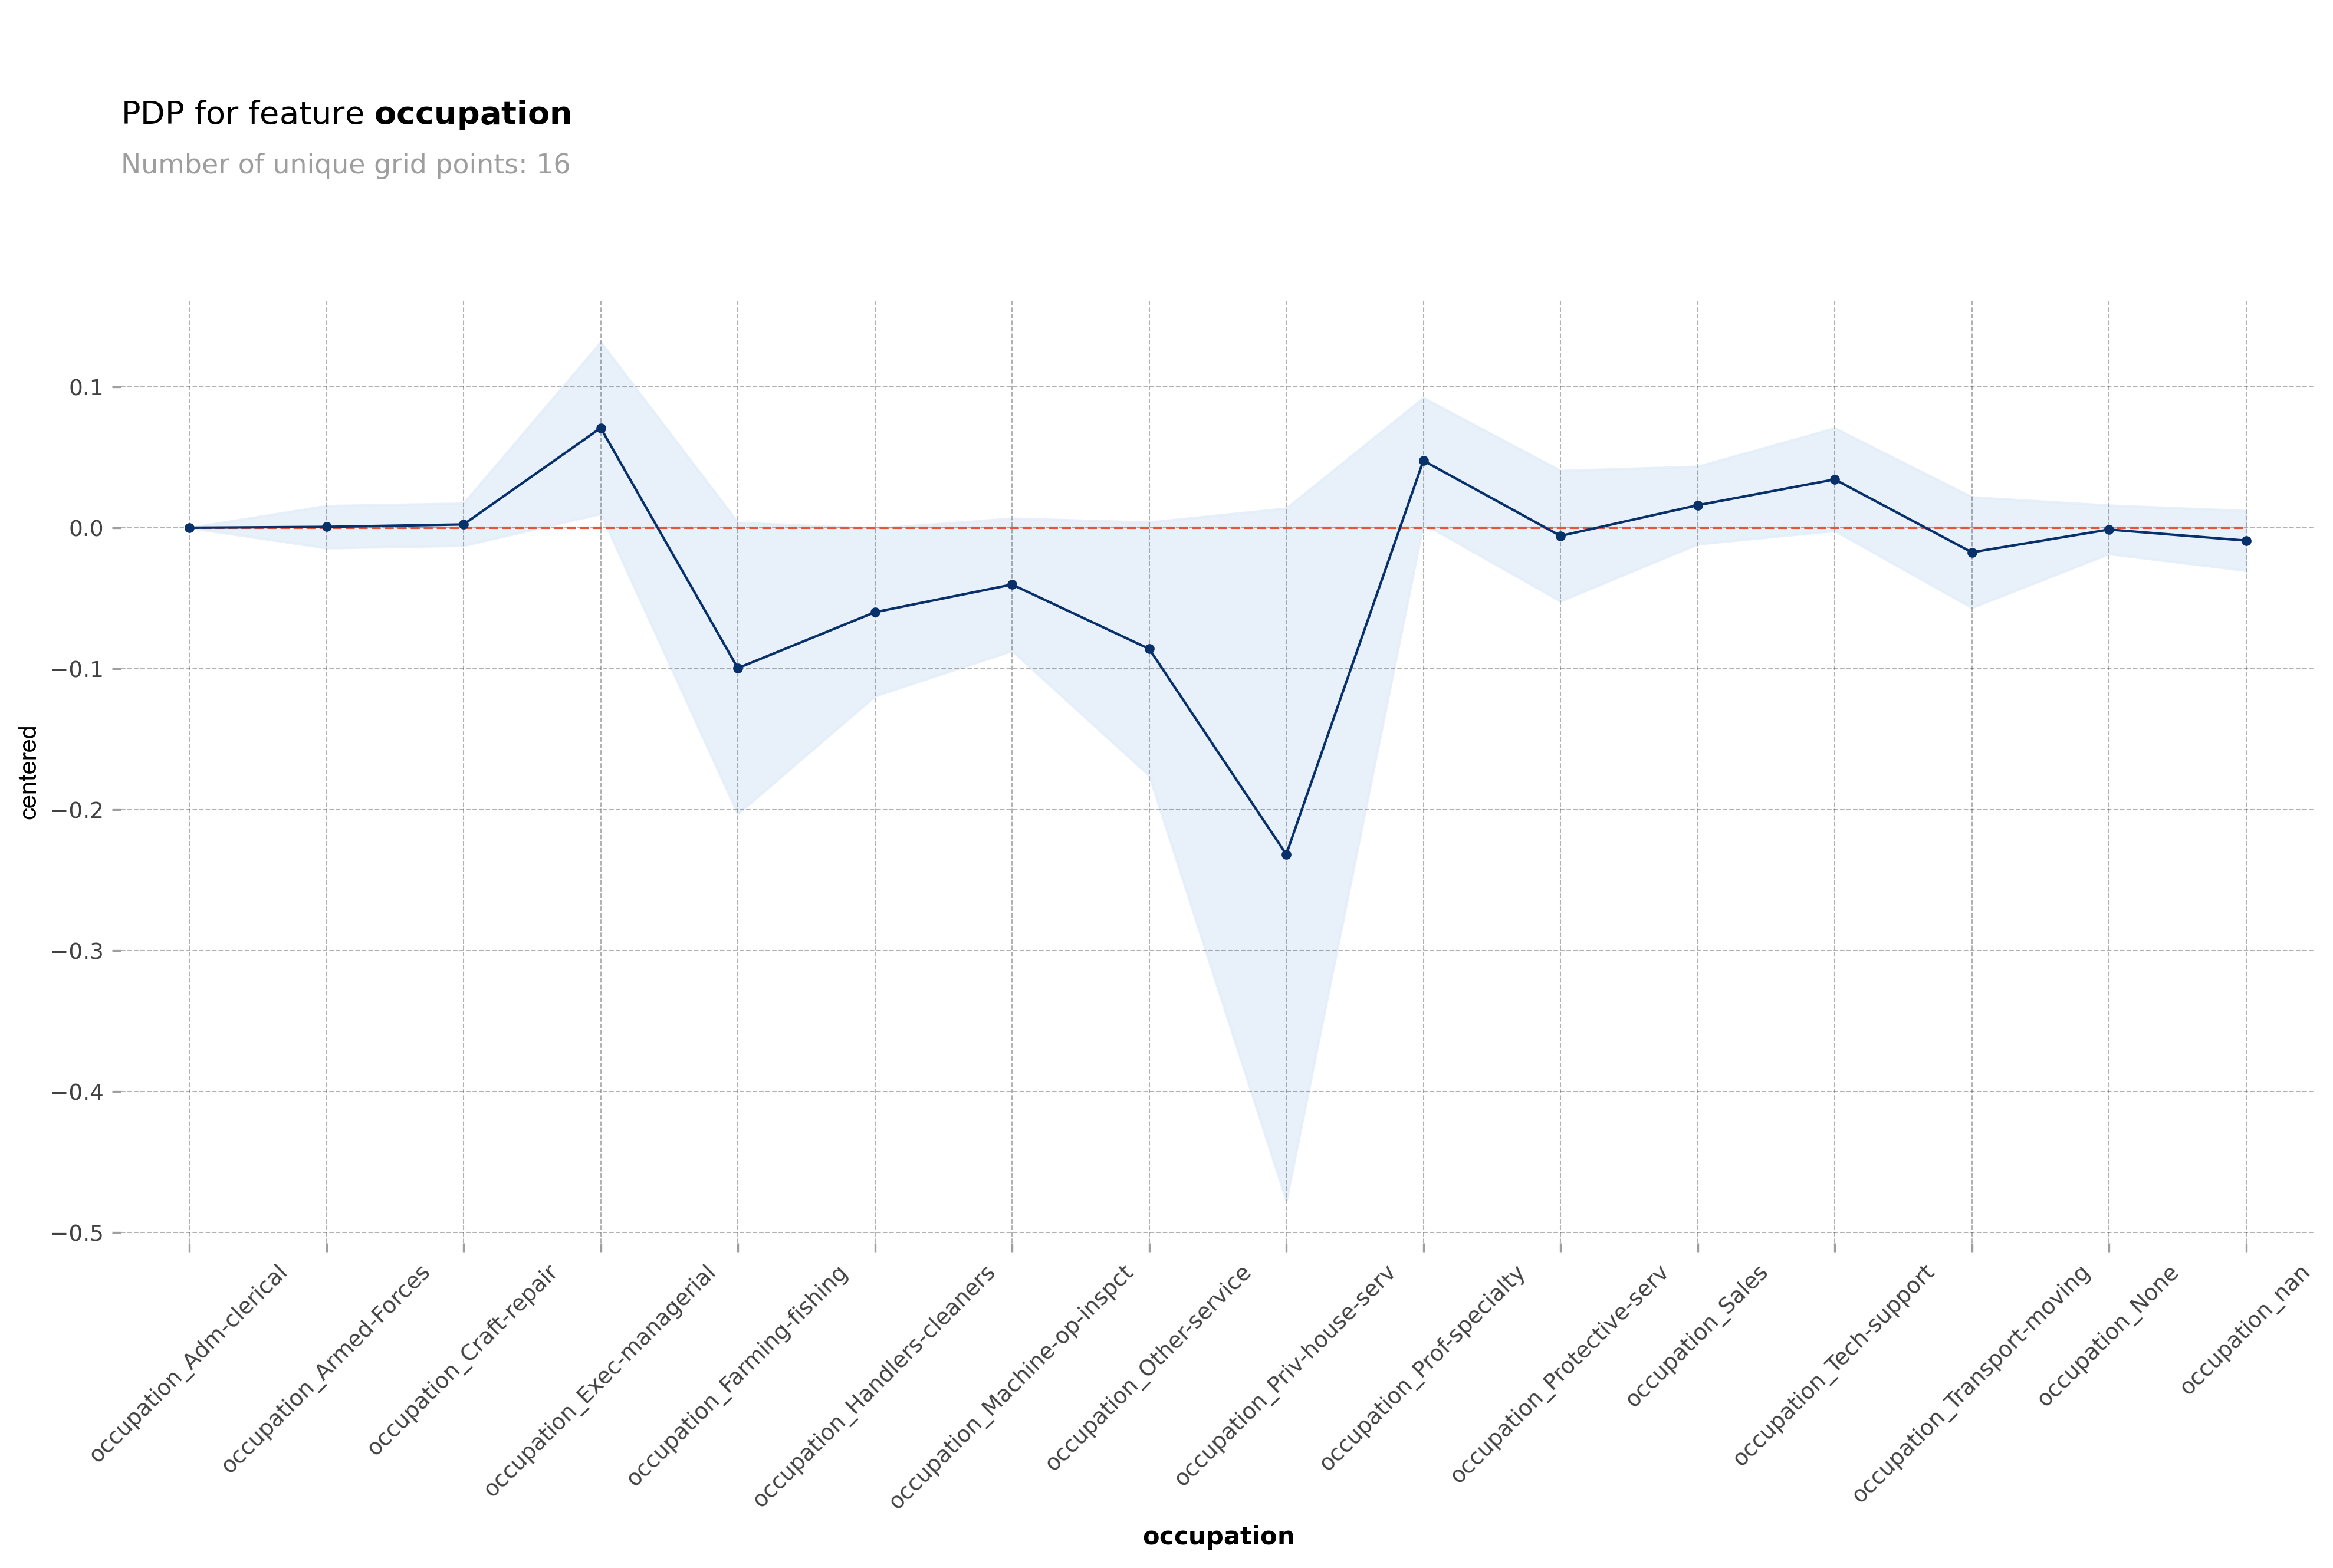

In [129]:
# occupation categorical
occup_columns = [col for col in X_full.columns if col.startswith("occupation_")]


# categorical feature
X_full_copy = X_full.copy()

pdp_occup = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature=occup_columns,
    feature_name="occupation",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_occup.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.xticks(rotation=45)

plt.show()

obtain pred_func from the provided model.


  0%|          | 0/6 [00:00<?, ?it/s]

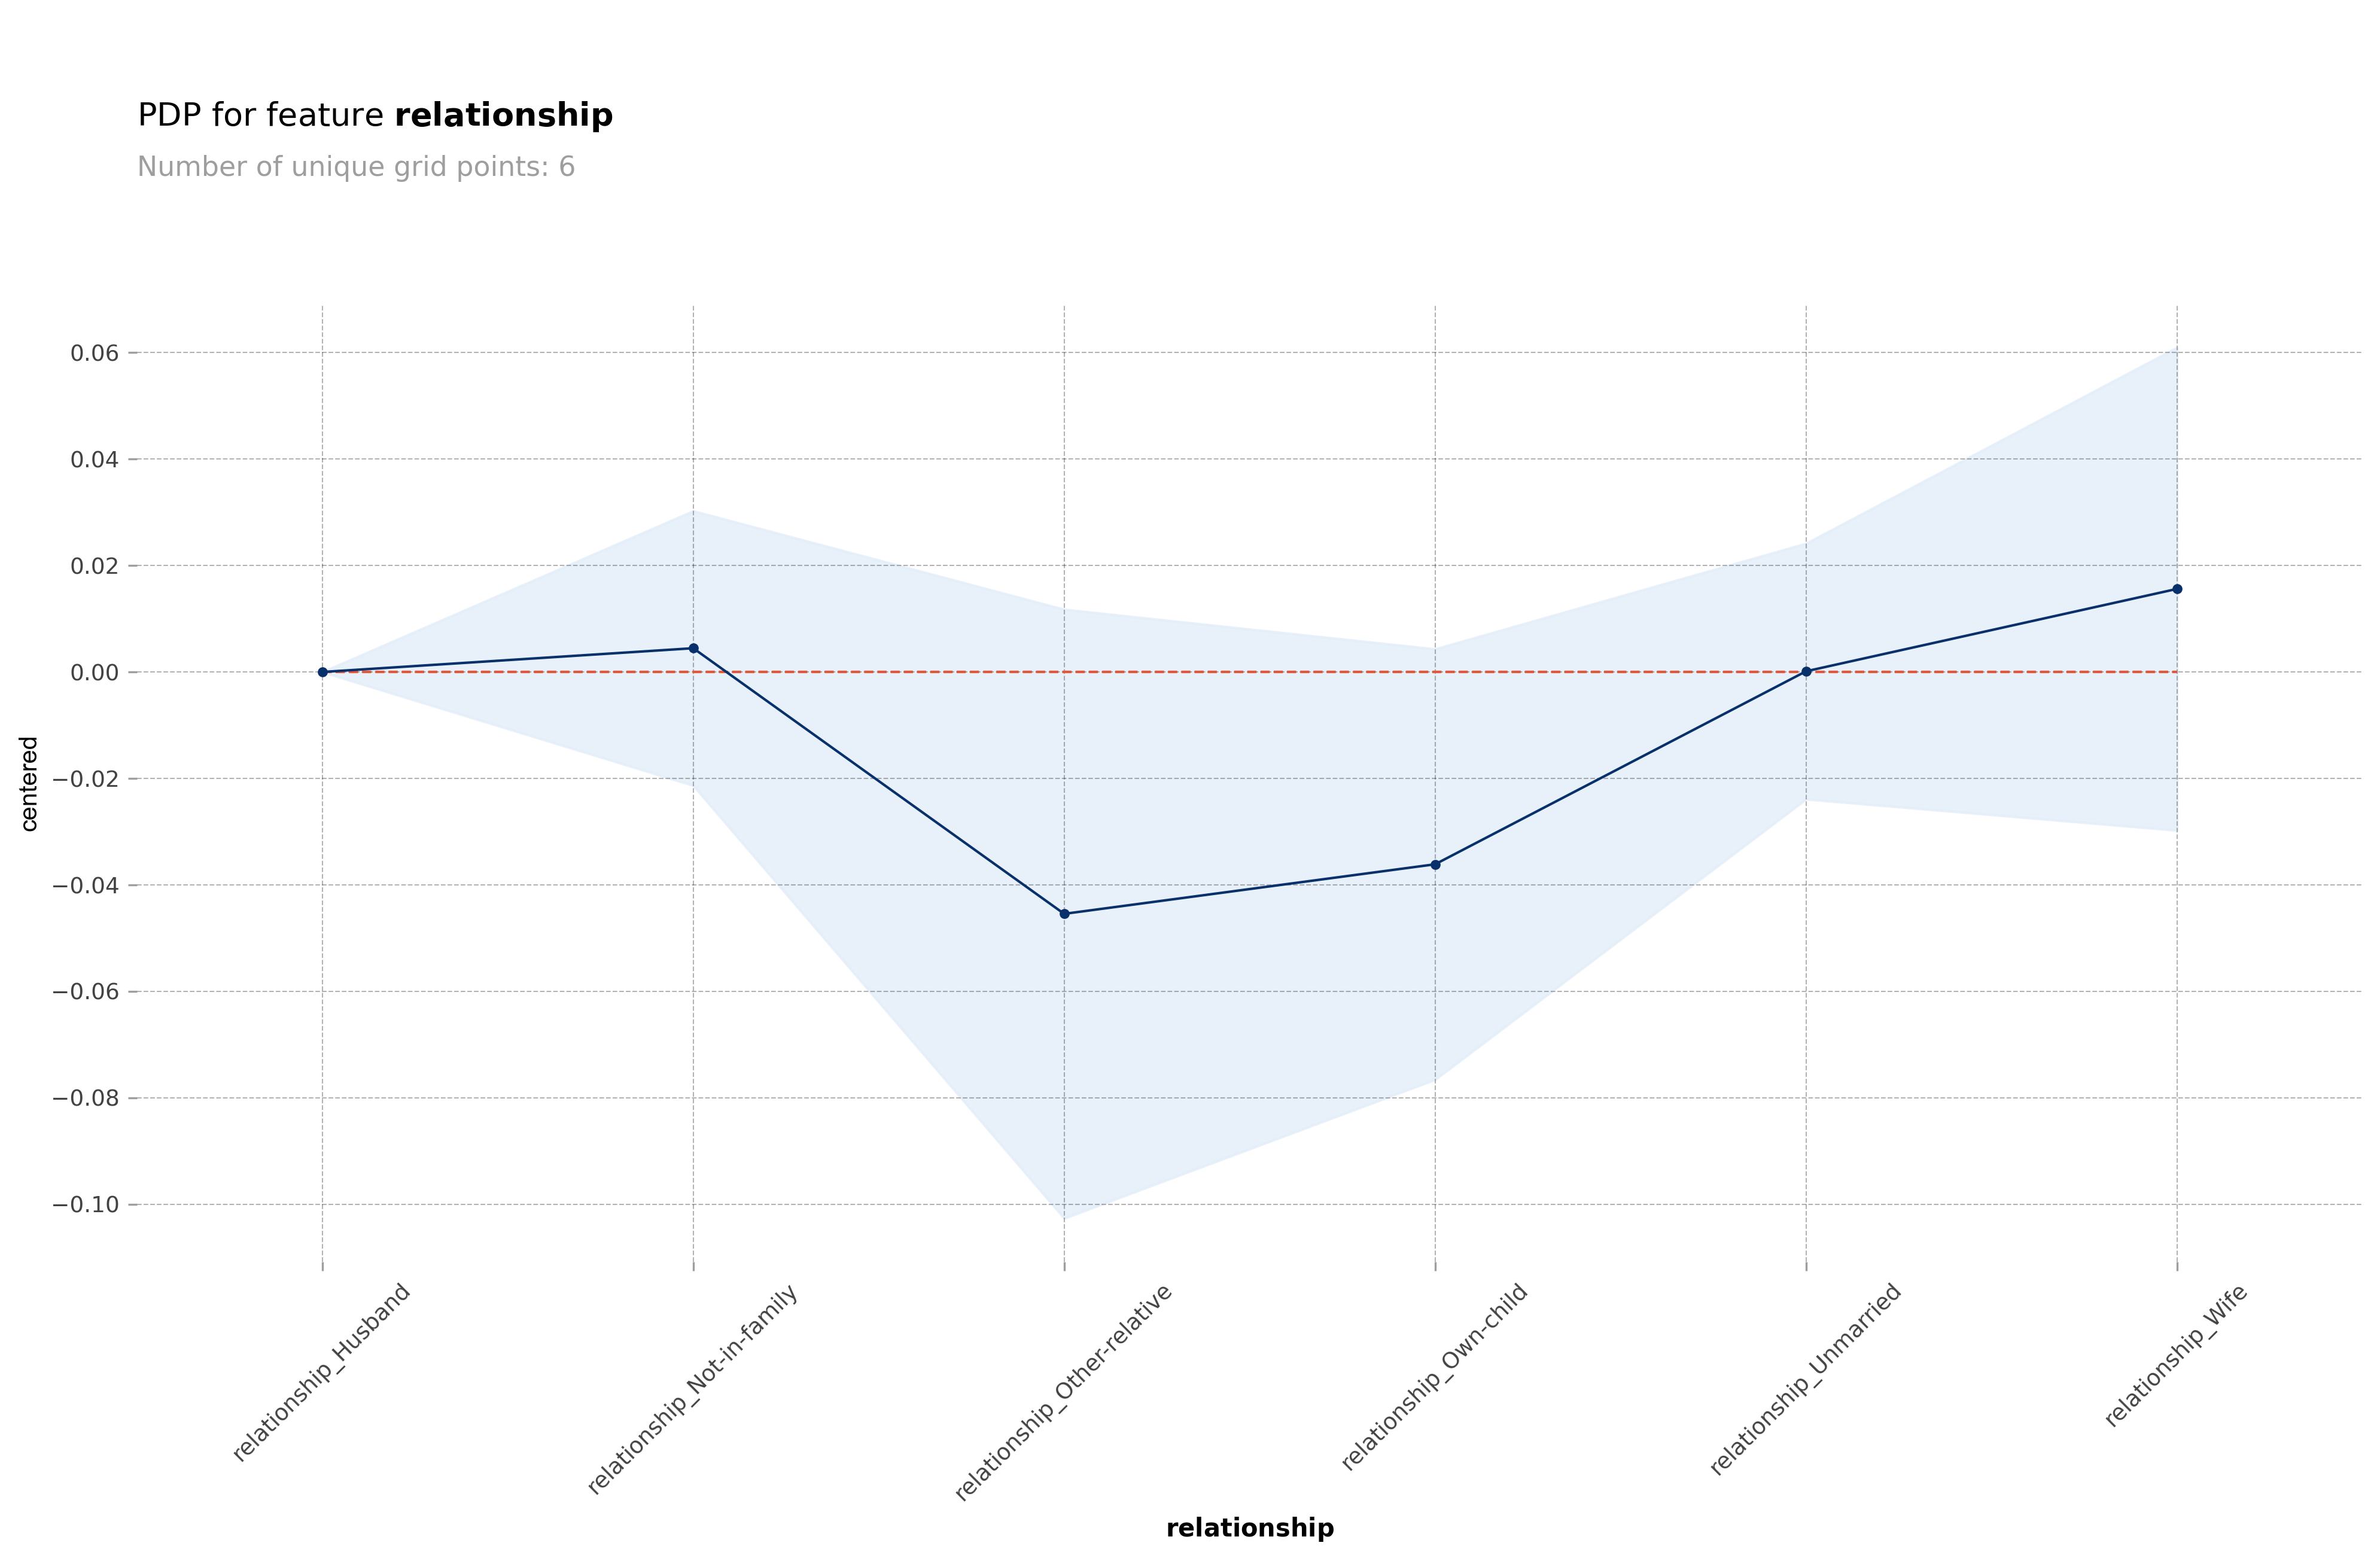

In [130]:
# relationship categorical
rel_columns = [col for col in X_full.columns if col.startswith("relationship_")]


# categorical feature
X_full_copy = X_full.copy()

pdp_rel = pdp.PDPIsolate(
    model=catboost_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature=rel_columns,
    feature_name="relationship",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_rel.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.xticks(rotation=45)

plt.show()

In [ ]:
# education category not neded
# fnl_weight not needed those columns are useless

### Local-agonistic methods 

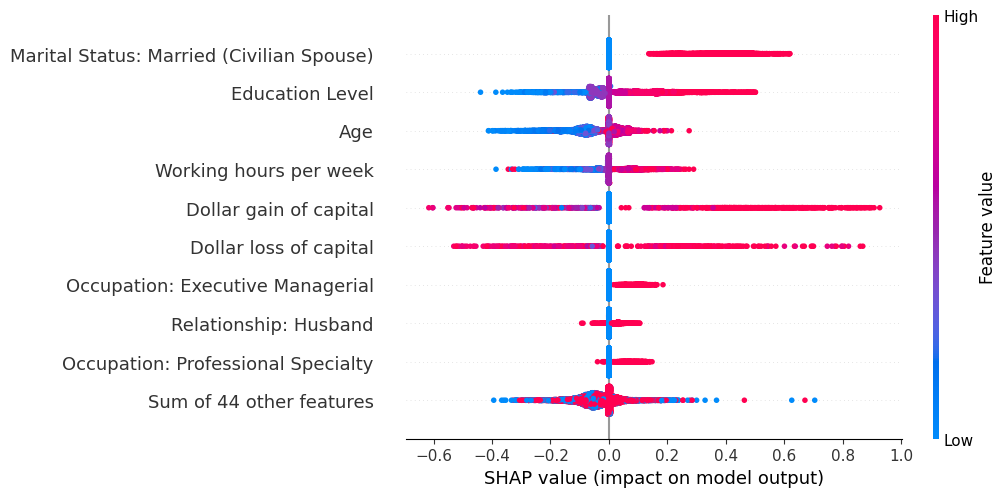

In [75]:
# SHAP Beeswarm Plot
shap.plots.beeswarm(shap_values)

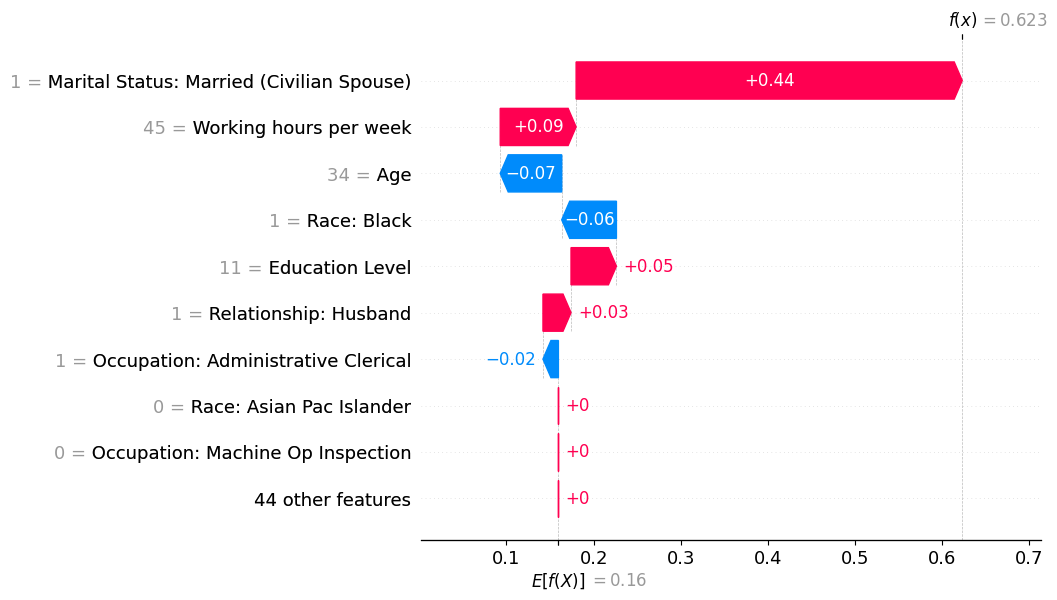

In [69]:
# SHAP Waterfall Plot (indvidual prediction)
shap.plots.waterfall(shap_values[11])

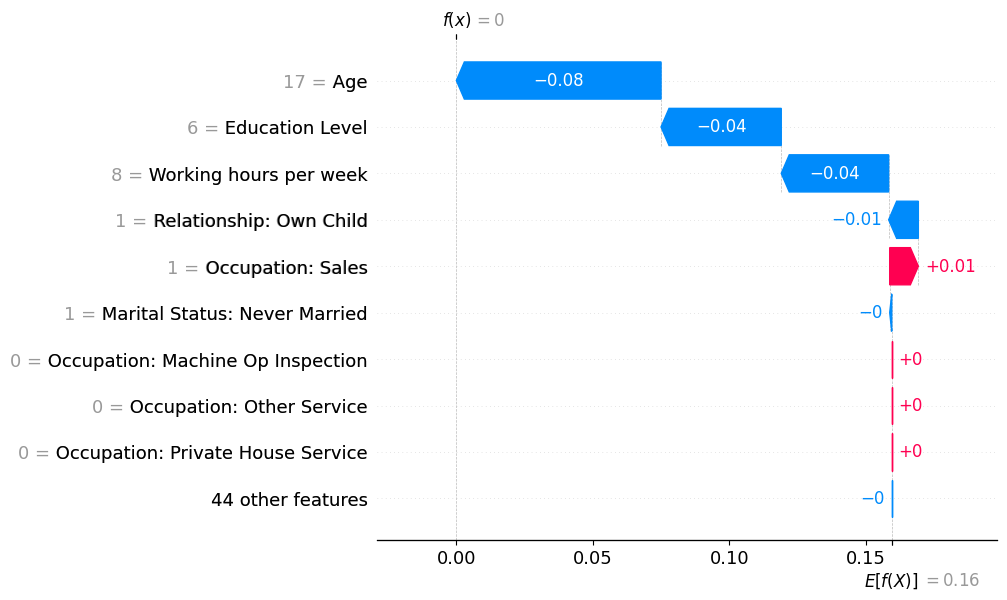

In [71]:
shap.plots.waterfall(shap_values[2233])

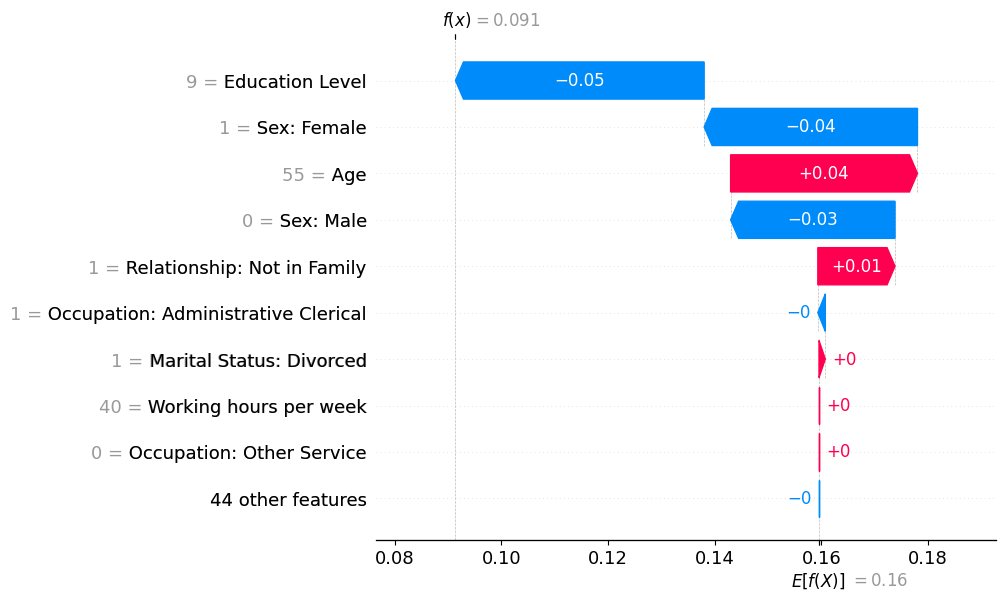

In [72]:
shap.plots.waterfall(shap_values[5478])

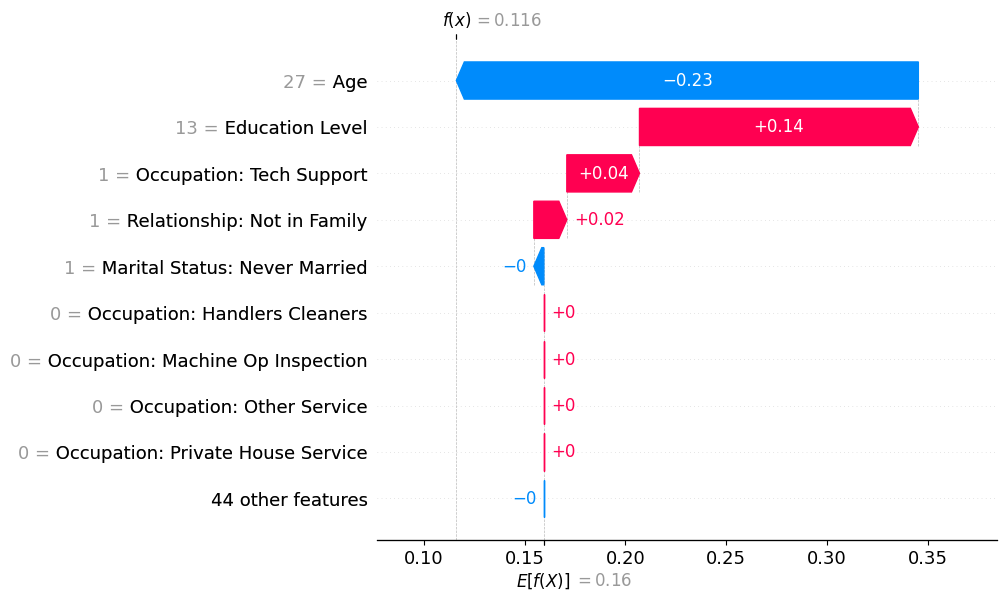

In [73]:
shap.plots.waterfall(shap_values[6740])

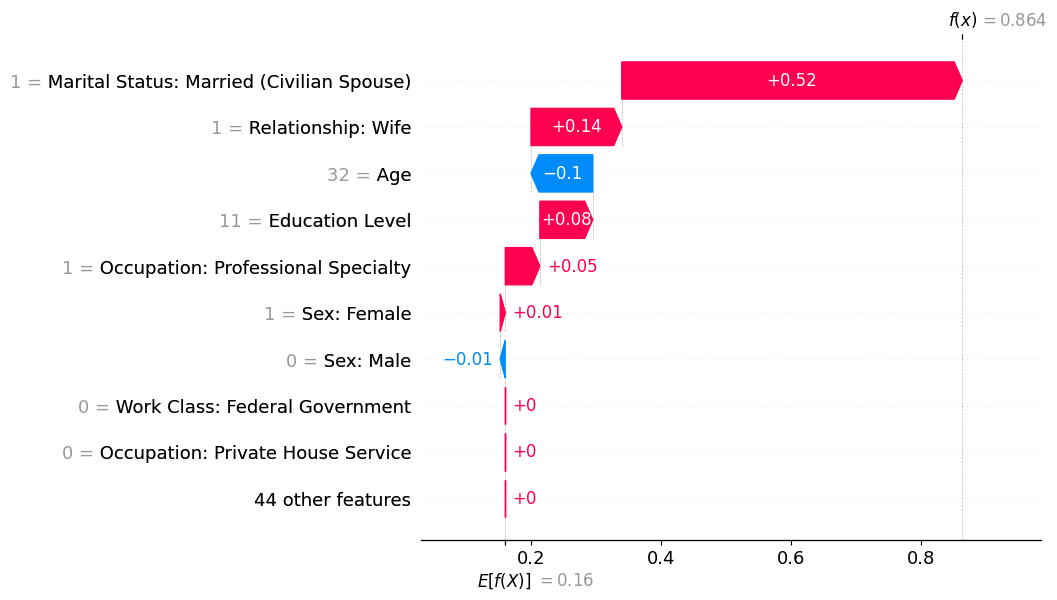

In [74]:
shap.plots.waterfall(shap_values[8901])

In [21]:
y_pred_proba = catboost_final.predict_proba(X_test_ss)[:, 1]
results = pd.DataFrame({"score": y_pred_proba})
results.index.name = "id"
results.to_csv("../40_results/catboost_prob.csv")

In [23]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
max_f1_index = np.argmax(f1_scores)
max_threshold = thresholds[max_f1_index]
max_f1 = f1_scores[max_f1_index]
max_f1

0.7356274469400371

## MAKE WEBSITE FOR USER INTERACTIVITY

In [58]:
# test to make sure the original hyperparemeters is good
data = pd.read_csv("../00_original_data/adult.csv")
data = data.replace("?", None)
data["income"] = data["income"].replace(
    {"<=50K.": 0, "<=50K": 0, ">50K": 1, ">50K.": 1}
)
data.insert(0, "income", data.pop("income"))
data["native-country_United-States"] = (
    data["native-country"] == "United-States"
).astype(int)
data.drop("native-country", axis=1, inplace=True)
numeric_cols = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]
# grab categroical cols
categorical_cols = [
    "native-country_United-States",
    "workclass",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
]

feature_names = data.columns.tolist()[1:]

In [59]:
feature_names.remove("fnlwgt")
feature_names.remove("education")
X = data[feature_names]
y = data["income"]

X_full, X_test, y_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
X_full.head()

age         workclass  education-num      marital-status  \
37193   32           Private              9  Married-civ-spouse   
31093   45         State-gov             14  Married-civ-spouse   
33814   35         Local-gov              8  Married-civ-spouse   
14500   64           Private              9            Divorced   
23399   63  Self-emp-not-inc              9             Widowed   

             occupation   relationship   race   sex  capital-gain  \
37193  Transport-moving        Husband  White  Male             0   
31093    Prof-specialty        Husband  White  Male             0   
33814   Farming-fishing        Husband  White  Male             0   
14500      Craft-repair      Unmarried  White  Male             0   
23399             Sales  Not-in-family  White  Male             0   

       capital-loss  hours-per-week  native-country_United-States  
37193             0              40                             1  
31093             0              40                             1  
33814             0              40                             1  
14500             0              20                             1  
23399             0              70                             1

In [61]:
na_counts = X_test.isna().sum()

# Printing the result
print(na_counts)

age                               0
workclass                       577
education-num                     0
marital-status                    0
occupation                      578
relationship                      0
race                              0
sex                               0
capital-gain                      0
capital-loss                      0
hours-per-week                    0
native-country_United-States      0
dtype: int64


In [62]:
X_full = X_full.fillna("Unknown")
X_test = X_test.fillna("Unknown")
X_full

age         workclass  education-num      marital-status  \
37193   32           Private              9  Married-civ-spouse   
31093   45         State-gov             14  Married-civ-spouse   
33814   35         Local-gov              8  Married-civ-spouse   
14500   64           Private              9            Divorced   
23399   63  Self-emp-not-inc              9             Widowed   
...    ...               ...            ...                 ...   
11284   35           Private             13  Married-civ-spouse   
44732   21           Private              9       Never-married   
38158   23           Private              9            Divorced   
860     18           Private              7       Never-married   
15795   50  Self-emp-not-inc              9  Married-civ-spouse   

              occupation   relationship                race     sex  \
37193   Transport-moving        Husband               White    Male   
31093     Prof-specialty        Husband               White    Male   
33814    Farming-fishing        Husband               White    Male   
14500       Craft-repair      Unmarried               White    Male   
23399              Sales  Not-in-family               White    Male   
...                  ...            ...                 ...     ...   
11284    Exec-managerial        Husband  Asian-Pac-Islander    Male   
44732  Machine-op-inspct      Own-child               White  Female   
38158       Adm-clerical  Not-in-family               White  Female   
860         Adm-clerical      Own-child               White  Female   
15795    Farming-fishing        Husband               White    Male   

       capital-gain  capital-loss  hours-per-week  \
37193             0             0              40   
31093             0             0              40   
33814             0             0              40   
14500             0             0              20   
23399             0             0              70   
...             ...           ...             ...   
11284             0          1887              50   
44732             0             0              40   
38158             0             0              40   
860               0             0              20   
15795             0             0              84   

       native-country_United-States  
37193                             1  
31093                             1  
33814                             1  
14500                             1  
23399                             1  
...                             ...  
11284                             0  
44732                             1  
38158                             1  
860                               1  
15795                             1  

[39073 rows x 12 columns]

In [63]:
# I need to train two models? one with all the features and some with top 5
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_full)
y_full = y_full.copy()
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_full)
class_weights = dict(zip(classes, weights))

best_params = {
    "boosting_type": "Ordered",
    "class_weights": class_weights,
    "depth": 10,
    "iterations": 800,
    "l2_leaf_reg": 14,
    "learning_rate": 0.40679084943595434,
    "logging_level": "Silent",
    "loss_function": "Logloss",
    "cat_features": categorical_cols,
}

website_model1 = CatBoostClassifier(**best_params)
website_model1.fit(X_full, y_full)

In [64]:
# no really dif of perforamnce now try with condensed model
y_pred_proba = website_model1.predict_proba(X_test)[:, 1]
auc_final = roc_auc_score(y_test, y_pred_proba)
ap_final = average_precision_score(y_test, y_pred_proba)
print("ROC_AUC score:", auc_final)
print("AP score:", ap_final)

ROC_AUC score: 0.9255409087186289
AP score: 0.8256985130755173


In [70]:
X_test.columns

Index(['age', 'workclass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country_United-States'],
      dtype='object')

In [84]:
feature_int = website_model1.get_feature_importance(fstr_type="Interaction")
for ft in feature_int:
    print(feature_names[int(ft[0])], feature_names[int(ft[1])], ft[2])

workclass relationship 4.954472239861408
marital-status occupation 4.442344452483187
marital-status relationship 4.2502267949441
workclass occupation 4.177692311070727
occupation relationship 4.058482759438991
workclass race 3.636206525917232
occupation race 3.6352426447891792
age occupation 2.976522169481447
marital-status race 2.9503500620488907
relationship capital-gain 2.930100630394368
workclass marital-status 2.7248992416729663
age relationship 2.6887270367570033
capital-gain hours-per-week 2.603230288724536
occupation hours-per-week 2.491996261078188
age capital-gain 2.484345519935602
relationship race 2.483102772994241
occupation capital-gain 2.440754533009934
age marital-status 2.190948824984217
capital-gain capital-loss 2.177755226545963
relationship capital-loss 2.0731040583271345
age race 2.019653595743134
relationship hours-per-week 2.0171251073832948
marital-status hours-per-week 1.9388518471690548
marital-status capital-gain 1.767452697658696
age workclass 1.574628001682

In [69]:
import pickle

filename = "websitemodel1.pkl"
pickle.dump(website_model1, open(filename, "wb"))
loaded_model = pickle.load(open(filename, "rb"))
y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]
auc_final = roc_auc_score(y_test, y_pred_proba)
ap_final = average_precision_score(y_test, y_pred_proba)
print("ROC_AUC score:", auc_final)
print("AP score:", ap_final)

ROC_AUC score: 0.9255409087186289
AP score: 0.8256985130755173


In [65]:
feature_names

['age',
 'workclass',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country_United-States']

In [49]:
# condensed model: age, martial-status, hours per week, occupation, and relationship
feature_names = [
    "age",
    "marital-status",
    "hours-per-week",
    "occupation",
    "education-num",
    "workclass",
]
categorical_cols = ["marital-status", "occupation", "workclass"]
X_subset = data[feature_names]
y = data["income"]

X_full, X_test, y_full, y_test = train_test_split(
    X_subset, y, test_size=0.2, random_state=42
)

X_full = X_full.fillna("Unknown")
X_test = X_test.fillna("Unknown")
X_full

age      marital-status  hours-per-week         occupation  \
37193   32  Married-civ-spouse              40   Transport-moving   
31093   45  Married-civ-spouse              40     Prof-specialty   
33814   35  Married-civ-spouse              40    Farming-fishing   
14500   64            Divorced              20       Craft-repair   
23399   63             Widowed              70              Sales   
...    ...                 ...             ...                ...   
11284   35  Married-civ-spouse              50    Exec-managerial   
44732   21       Never-married              40  Machine-op-inspct   
38158   23            Divorced              40       Adm-clerical   
860     18       Never-married              20       Adm-clerical   
15795   50  Married-civ-spouse              84    Farming-fishing   

       education-num         workclass  
37193              9           Private  
31093             14         State-gov  
33814              8         Local-gov  
14500              9           Private  
23399              9  Self-emp-not-inc  
...              ...               ...  
11284             13           Private  
44732              9           Private  
38158              9           Private  
860                7           Private  
15795              9  Self-emp-not-inc  

[39073 rows x 6 columns]

In [67]:
X_full["sex"].unique().tolist()

['Male', 'Female']

In [35]:
classes = np.unique(y_full)
y_full = y_full.copy()
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_full)
class_weights = dict(zip(classes, weights))

# implement random search to find good params
param_grid = {
    "depth": [2, 6, 8, 10, 12, 14],
    "learning_rate": loguniform(1e-5, 1e-0),
    "iterations": [500, 800, 1000, 1200],
    "l2_leaf_reg": [2, 4, 6, 8, 10, 12, 14],
    "boosting_type": ["Ordered"],
    "logging_level": ["Silent"],
    "loss_function": ["Logloss"],
    "class_weights": [class_weights],
    "cat_features": [categorical_cols],
}

random_search = RandomizedSearchCV(
    estimator=CatBoostClassifier(),
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
)

random_search.fit(X_full, y_full)
print("Catboost random search model has been fitted")

Catboost random search model has been fitted


In [51]:
best_params = {
    "boosting_type": "Ordered",
    "class_weights": class_weights,
    "depth": 10,
    "iterations": 800,
    "l2_leaf_reg": 14,
    "learning_rate": 0.40679084943595434,
    "logging_level": "Silent",
    "loss_function": "Logloss",
    "cat_features": categorical_cols,
}

website_model2 = CatBoostClassifier(**best_params)
website_model2.fit(X_full, y_full)

In [53]:
# somewhat big difference in performance but still okay
y_pred_proba = website_model2.predict_proba(X_test)[:, 1]
auc_final = roc_auc_score(y_test, y_pred_proba)
ap_final = average_precision_score(y_test, y_pred_proba)
print("ROC_AUC score:", auc_final)
print("AP score:", ap_final)

ROC_AUC score: 0.8869075090048836
AP score: 0.7052445926771601


In [54]:
# save models for use in website
import pickle

filename = "websitemodel2.sav"
pickle.dump(website_model2, open(filename, "wb"))
loaded_model = pickle.load(open(filename, "rb"))
y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]
auc_final = roc_auc_score(y_test, y_pred_proba)
ap_final = average_precision_score(y_test, y_pred_proba)
print("ROC_AUC score:", auc_final)
print("AP score:", ap_final)

ROC_AUC score: 0.8869075090048836
AP score: 0.7052445926771601
